In [2]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

Load functions used in Notebook

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

# create function df_axes to set dark gray axes
dg = (.25, .25, .25, .25) # dark gray

# format figure
def dg_axes():
    # set whitegrid style
    sns.set_style("whitegrid")
    for ax in plt.gcf().axes:
        ax.spines['bottom'].set_color(dg)
        ax.spines['left'].set_color(dg)
        #set spine linewidth to 1
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        for p in ax.patches:
            p.set_edgecolor(dg)
            p.set_linewidth(1)


def set_figure_width(columns=1,  ratio_wh=1, custom_width_cm=None):
    """Set the figure width based on the number of columns or a custom width.
    
    Parameters:
    columns (int, float): Number of columns to set width. Accepted values are 1, 1.5, 2.
    custom_width_cm (float): Custom width in cm. If provided, it will override the columns parameter.
    """    
    
    column_widths = {
        1: 8.9,
        1.5: 13.6,
        2: 18.3
    }
    
    if columns is not None and columns in column_widths:
        column_width = column_widths[columns]
        width_inches = column_width / 2.54
        height_inches = width_inches * ratio_wh
        plt.gcf().set_size_inches(width_inches, height_inches)
    elif custom_width_cm is not None:
        width_inches = custom_width_cm / 2.54
        height_inches = width_inches * ratio_wh
        plt.gcf().set_size_inches(width_inches, height_inches)
    else:
        print(f"Invalid 'columns' value: {columns}. Accepted values are 1, 1.5, 2.")
        return

# Example usage
plt.figure()
set_figure_width(1,.5)  # For one column

<Figure size 350.394x175.197 with 0 Axes>

In [4]:
def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path

Load models

In [5]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "August2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [6]:
# select only models containing Lukowski in their name 
model_list = [model for model in model_list if 'Lukowski' in model.id \
                        or 'Human-GEM' in model.id\
                        or 'control' in model.id]
model_list

[<Model Human-GEM_28062023 at 0x12c20778880>,
 <Model mod_RPE_PRcone_Lukowski at 0x12c792d6590>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x12c8031f1c0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x12c8f782c80>,
 <Model mod_RPE_PRcontrol at 0x12c946329e0>,
 <Model mod_RPE_PRrod_Lukowski at 0x12d04ac0250>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x12d0f432d10>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x12d11c595d0>]

Modify models (set objective function and close exchange bounds)

In [7]:
# modify models

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
        m.reactions.get_by_id('MAR03964_PR').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
        m.reactions.get_by_id('MAR03964_RPE').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
        m.reactions.get_by_id('MAR03964').bounds = (-1000,1000)
        m.objective.direction = 'max'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# allow all metabolites out (open efflux) and open influx for water
for m in model_list:
    for r in [r for r in m.reactions if len(r.products) == 0]:
        r.bounds = (0,0)
    for r in [r for r in m.reactions if len(r.products) == 0  if '_eRPE_PR' not in r.id]:  # open efflux for exchange reactions (except for with the RPE-PR[e] interface)
        r.bounds=(0,1000)
    for r in [r for r in m.reactions if 'MAR09047' in r.id and '_eRPE_PR' not in r.id]: # MAR09047: water
        r.bounds=(-1000,1000) 

Check out some basic features of some of the models

In [8]:
model_list[0].reactions.get_by_id('MAR03964')

Reaction identifier,MAR03964
Name,ATP phosphohydrolase
Memory address,0x12c281e50f0
Stoichiometry,MAM01371c + MAM02040c <=> MAM01285c + MAM02039c + MAM02751c ATP + H2O <=> ADP + H+ + Pi
GPR,
Lower bound,-1000
Upper bound,1000


In [9]:
print('list of H2O exchange reactions in model at position 1 in model_list:')
[r for r in model_list[1].reactions if 'MAR09047' in r.id]

list of H2O exchange reactions in model at position 1 in model_list:


[<Reaction MAR09047_RPE at 0x12c803b52a0>,
 <Reaction MAR09047_eRPE_PR at 0x12c834c5600>,
 <Reaction MAR09047_PR at 0x12c862c9ab0>]

In [10]:
print('H2O exchange bounds with PR: ' + str(model_list[1].reactions.get_by_id('MAR09047_PR').bounds))
print('H2O exchange bounds with RPE: ' + str(model_list[1].reactions.get_by_id('MAR09047_RPE').bounds))
print('H2O exchange bounds with RPE-PR interface: ' + str(model_list[1].reactions.get_by_id('MAR09047_eRPE_PR').bounds))

H2O exchange bounds with PR: (-1000, 1000)
H2O exchange bounds with RPE: (-1000, 1000)
H2O exchange bounds with RPE-PR interface: (0, 0)


In [11]:
single_models

[<Model mod_RPE_PRcone_Lukowski_singlePR at 0x12c8031f1c0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x12c8f782c80>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x12d0f432d10>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x12d11c595d0>]

In [12]:
Human1_models

[<Model Human-GEM_28062023 at 0x12c20778880>]

In [13]:
Human1_models[0].reactions.get_by_id('MAR03964')

Reaction identifier,MAR03964
Name,ATP phosphohydrolase
Memory address,0x12c281e50f0
Stoichiometry,MAM01371c + MAM02040c <=> MAM01285c + MAM02039c + MAM02751c ATP + H2O <=> ADP + H+ + Pi
GPR,
Lower bound,-1000
Upper bound,1000


Load blood exchange bounds

In [14]:
# load blood exchange bounds
import pandas as pd
df = pd.read_excel(Path().cwd() / 'rxn_bounds/blood_selection.xlsx') # with col names 'id' 'lb' 'ub'
blood_ratio = {df['id_single'][i]:df['ratio [glucose]/[x]'] [i] for i in range(len(df['id']))}

# dictionary comprehension to replace values with 50% and 10% values in dict
blood_ratio200 = {k:2*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio100 = {k:1*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio50 = {k: 0.5*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio25 = {k: 0.25*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio0 = {k: 0.00*blood_ratio[k] for k in blood_ratio.keys()}

br_list = [blood_ratio200, blood_ratio100, blood_ratio50, blood_ratio25, blood_ratio0]

blood_ratio

{'MAR09034': 1.0,
 'MAR09063': 0.12618432385874245,
 'MAR09061': 0.090869939707149,
 'MAR09067': 0.05555555555555555,
 'MAR09041': 0.050818260120585705,
 'MAR09046': 0.05017226528854436,
 'MAR09068': 0.0409130060292851,
 'MAR09044': 0.03574504737295435,
 'MAR09069': 0.03229974160206718,
 'MAR09040': 0.026485788113695088,
 'MAR09038': 0.023040482342807925,
 'MAR09066': 0.017226528854435832,
 'MAR09064': 0.016731266149870805,
 'MAR09043': 0.01309216192937123,
 'MAR09065': 0.01119724375538329,
 'MAR09045': 0.009474590869939707,
 'MAR09071': 0.009323858742463394,
 'MAR09062': 0.008828596037898364,
 'MAR09042': 0.005383290267011197,
 'MAR09070': 0.0032730404823428077,
 'MAR11961': 0.00014857881136950905,
 'MAR09039': 0.014233419465977604}

In [15]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

lactate_ID = 'MAR09135'
glucose_ID = 'MAR09034'
oxygen_ID = 'MAR09048'

##############################################################
#######    total exchange (for single models)        #########
##############################################################

# PERIFOVEAL
single_ex_bounds_dark_perifoveal = {'MAR09048':(-4.04,-4.04),\
                      'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(8.34,8.34)}

single_ex_bounds_light_perifoveal  = {'MAR09048':(-2.76,-2.76),\
                       'MAR09034':(-2.04,-2.04),\
                        'MAR09135':(4.21,4.21)}

# FOVEAL
single_ex_bounds_dark_foveal = {'MAR09048':(-2.72,-2.72),\
                      'MAR09034':(-2.89,-2.89),\
                        'MAR09135':(5.00,5.00)}

single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
                       'MAR09034':(-1.51,-1.51),\
                        'MAR09135':(3.11,3.11)}


##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

# PERIFOVEAL
ex_bounds_dark_perifoveal  = {'MAR09048_RPE':(-3.48,-3.48),\
                     'MAR04896_PR_RPE':(-3.18,-3.18),\
                      'MAR09034_RPE':(-4.14,-4.14),\
                      'MAR09135_RPE':(7.18,7.18),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(-0.67,-0.67),\
                      'MAR09135_PR':(1.16,1.16)}          

ex_bounds_light_perifoveal  = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR04896_PR_RPE':(-2.19,-2.19),\
                      'MAR09034_RPE':(-1.84,-1.84),\
                      'MAR09135_RPE':(3.79,3.79),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(-0.20,-0.20),\
                      'MAR09135_PR':(0.41,0.41)}

# FOVEAL
ex_bounds_dark_foveal = {'MAR09048_RPE':(-2.72,-2.72),\
                     'MAR04896_PR_RPE':(-2.42,-2.42),\
                      'MAR09034_RPE':(-2.89,-2.89),\
                      'MAR09135_RPE':(5,5)}          

ex_bounds_light_foveal = {'MAR09048_RPE':(-2.34,-2.34),\
                      'MAR04896_PR_RPE':(-2.04,-2.04),\
                      'MAR09034_RPE':(-1.51,-1.51),\
                      'MAR09135_RPE':(3.11,3.11)}

Load functions for setting blood exchange 

In [16]:
def get_lactate_proportions(ex_bounds):
    # for combined models only
    lactate_RPE = ex_bounds['MAR09135_RPE'][0]  # Assuming lower and upper bounds are the same
    lactate_PR = ex_bounds['MAR09135_PR'][0]   # Assuming lower and upper bounds are the same

    total_lactate = lactate_RPE + lactate_PR

    lactate_RPEp = lactate_RPE / total_lactate if total_lactate != 0 else 0  # Protect against division by zero
    lactate_PRp = lactate_PR / total_lactate if total_lactate != 0 else 0   # Protect against division by zero

    return lactate_RPEp, lactate_PRp

def open_blood_exchange(mod,br, glucose_level, RPE_PR = 'RPE'):  
    # for single models only
    suffix = '_PR' if RPE_PR == 'PR' \
        else '_RPE' if RPE_PR == 'RPE' \
        else '' if RPE_PR == '' \
        else print('RPE_PR must be PR, RPE or empty string')

    br_updated = br.copy()
    br_updated.update((x, y * glucose_level) for x, y in br_updated.items())
    for key in br:
        if key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = (br_updated[key],1000)# allow influx for RPE exchange reactions (blood exchange)
        elif key + suffix in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + suffix).bounds = (br_updated[key],1000)
        elif key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = (br_updated[key],1000)
        elif key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = (br_updated[key],1000)
        else: 
            print(key + ' not in model')
    return mod


def get_gluc(b, RPE_PR = ''):
    ## function to get glucose (MAR09034) value from dict (with 'RPE', 'PR', or without suffix)
    if any('MAR09034' in key for key in b.keys()):
        if RPE_PR == 'RPE':
            return b['MAR09034_RPE'][0]
        elif RPE_PR == 'PR':
            return b['MAR09034_PR'][0]
        elif RPE_PR == '':
            return b['MAR09034'][0]
    else:
        return print('MAR09034 not in dict')
    
def optimize_model(m,b,region='foveal',model_type='combined'):
    """"
    m: model
    b: blood exchange bounds
    region: 'foveal' or 'perifoveal'
    model_type: 'combined' or 'single'  
    
    """  
    if model_type == 'combined':
        m = open_blood_exchange(m,br, get_gluc(b, 'RPE'), 'RPE')
        if region == 'perifoveal':
            m = open_blood_exchange(m,br,   get_gluc(b, 'PR'), 'PR')
        for ex in b.keys(): 
            m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds
        m.optimize()
    
    if model_type == 'single':
        m = open_blood_exchange(m,br, get_gluc(b, ''), '')
        reactions_list = [r.id for r in m.reactions]
        for ex in b.keys(): 
            if (ex + '_RPE') in reactions_list:
                m.reactions.get_by_id(ex + '_RPE').bounds = b[ex] # set exchange bounds
            elif (ex + '_PR') in reactions_list:
                m.reactions.get_by_id(ex + '_PR').bounds = b[ex] # set exchange bounds
            elif (ex) in reactions_list:
                m.reactions.get_by_id(ex).bounds = b[ex]
            else:
                print('exchange reaction not found')
        m.optimize()

    return m.objective.value

Run main analysis for combined models

(FBA with different amino acid concentrations with light/dark perifoveal/foveal exchange bounds)

In [17]:
##############################################################
##############     for combined models      ##################
##############################################################

results_dict_dark = {}
results_dict_light = {}
results_dict_dark_foveal = {}
results_dict_light_foveal = {}

for model in combined_models:
    with model as m:
        for br in br_list:
            results_dict_dark[str(m.id) + str(list(br.values())[0])]  = optimize_model(m,ex_bounds_dark_perifoveal, 'perifoveal', 'combined')
            results_dict_light[str(m.id) + str(list(br.values())[0])] = optimize_model(m,ex_bounds_light_perifoveal, 'perifoveal', 'combined')
            results_dict_dark_foveal[str(m.id) + str(list(br.values())[0])] = optimize_model(m,ex_bounds_dark_foveal, 'foveal', 'combined')
            results_dict_light_foveal[str(m.id) + str(list(br.values())[0])] = optimize_model(m,ex_bounds_light_foveal, 'foveal', 'combined')

data_dicts = [(results_dict_light, 'light_perifoveal'),
            (results_dict_dark, 'dark_perifoveal'),
            (results_dict_light_foveal, 'light_foveal'),
            (results_dict_dark_foveal, 'dark_foveal')]

results1 = pd.concat([pd.DataFrame(data, index=[label]).T for data, label in data_dicts],axis=1)

results1

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

,light_perifoveal,dark_perifoveal,light_foveal,dark_foveal
mod_RPE_PRcone_Lukowski2.0,17.927194,30.611575,16.455471,21.584991
mod_RPE_PRcone_Lukowski1.0,17.585718,30.043288,16.142861,21.218746
mod_RPE_PRcone_Lukowski0.5,8.248779,29.759144,6.040234,21.035473
mod_RPE_PRcone_Lukowski0.25,None,29.617072,None,20.924668
mod_RPE_PRcone_Lukowski0.0,None,27.900000,None,15.497500
mod_RPE_PRcontrol2.0,18.415882,31.861471,16.85207,22.379329
mod_RPE_PRcontrol1.0,17.808396,30.667099,16.335176,21.612051
mod_RPE_PRcontrol0.5,16.935432,30.069913,14.332613,21.228412
mod_RPE_PRcontrol0.25,9.699103,29.771320,8.138807,21.012995
mod_RPE_PRcontrol0.0,None,28.500000,None,17.537500


Run main analysis for single models

(FBA with different amino acid concentrations with light/dark perifoveal/foveal exchange bounds)

In [18]:
for model in single_models:
    with model as m:
        for br in br_list:
            results_dict_dark[str(m.id) + str(list(br.values())[0])]  = optimize_model(m,single_ex_bounds_dark_perifoveal, 'perifoveal', 'single')
            results_dict_light[str(m.id) + str(list(br.values())[0])] = optimize_model(m,single_ex_bounds_light_perifoveal, 'perifoveal', 'single')
            results_dict_dark_foveal[str(m.id) + str(list(br.values())[0])] = optimize_model(m,single_ex_bounds_dark_foveal, 'foveal', 'single')
            results_dict_light_foveal[str(m.id) + str(list(br.values())[0])] = optimize_model(m,single_ex_bounds_light_foveal, 'foveal', 'single')

data_dicts = [(results_dict_light, 'light_perifoveal'),
            (results_dict_dark, 'dark_perifoveal'),
            (results_dict_light_foveal, 'light_foveal'),
            (results_dict_dark_foveal, 'dark_foveal')]

results2 = pd.concat([pd.DataFrame(data, index=[label]).T for data, label in data_dicts],axis=1)
results2

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

,light_perifoveal,dark_perifoveal,light_foveal,dark_foveal
mod_RPE_PRcone_Lukowski2.0,17.927194,30.611575,16.455471,21.584991
mod_RPE_PRcone_Lukowski1.0,17.585718,30.043288,16.142861,21.218746
mod_RPE_PRcone_Lukowski0.5,8.248779,29.759144,6.040234,21.035473
mod_RPE_PRcone_Lukowski0.25,None,29.617072,None,20.924668
mod_RPE_PRcone_Lukowski0.0,None,27.900000,None,15.497500
mod_RPE_PRcontrol2.0,18.415882,31.861471,16.85207,22.379329
mod_RPE_PRcontrol1.0,17.808396,30.667099,16.335176,21.612051
mod_RPE_PRcontrol0.5,16.935432,30.069913,14.332613,21.228412
mod_RPE_PRcontrol0.25,9.699103,29.771320,8.138807,21.012995
mod_RPE_PRcontrol0.0,None,28.500000,None,17.537500


Process resulting tables for figures 

In [19]:
#combine results1 and results2
results = pd.concat([results1,results2], axis = 0)
# melt results to long format
results_long = results.reset_index()
results_long = results_long.rename(columns = {'index':'model'})
results_long = results_long.melt(id_vars = 'model', var_name = 'light/dark_region', value_name = 'maximal ATP yield (pmol/s/mm^2)')
#combine results1 and results2
results = pd.concat([results1,results2], axis = 0)
# melt results to long format
results_long = results.reset_index()
results_long = results_long.rename(columns = {'index':'model'})
results_long = results_long.melt(id_vars = 'model', var_name = 'light/dark_region', value_name = 'maximal ATP yield (pmol/s/mm^2)')
# for model column in results_long, pattern recognition 'single' and move to new column 'model type'
# if model column contains 'single' or 'Human1' put 'single in column 'model type' otherwise put 'combined'
results_long['single/combined'] = ['single' if 'single' in model else 'single' if 'Human' in model else 'combined' for model in results_long['model']]
# add column with last number (2.0,1.0,0.5,0.25, or 0.0) of model column
results_long['aa_ratio'] = [model[-3:] for model in results_long['model']]
# if patern 'mod_RPE_PRcone' AND 'single' in model columns, put 'PR cone' in column 'cell'
m1 = ['PR cone' if 'mod_RPE_PRcone' in model and 'singlePR' in model else '' for model in results_long['model']]
m2 = ['RPE - PR cone' if 'mod_RPE_PRcone' in model and 'single' not in model else '' for model in results_long['model']]
m3 = ['PR rod' if 'mod_RPE_PRrod' in model and 'singlePR' in model else '' for model in results_long['model']]
m4 = ['RPE - PR rod' if 'mod_RPE_PRrod' in model and 'single' not in model else ''  for model in results_long['model']]
m5 = ['RPE' if 'singleRPE' in model else ''  for model in results_long['model']]
m6 = ['RPE - PR control' if 'control' in model and 'single' not in model else ''  for model in results_long['model']]
m7 = ['control' if 'Human' in model else ''  for model in results_long['model']]
# split up dark/light column into dark/light and foveal/perifoveal
m8 = ['dark' if 'dark' in model else 'light' if 'light' in model else '' for model in results_long['light/dark_region']]
m9 = ['perifoveal' if 'perifoveal' in model else 'foveal' if 'foveal' in model else '' for model in results_long['light/dark_region']] 
results_long['cell'] = [m1[i] + m2[i] + m3[i] + m4[i] + m5[i]+ m6[i] + m7[i] for i in range(len(m1))] # combine m1 to m5 in one columns 'cell'
results_long['region'] = m9 # combine m9 into column 'region'
results_long['light/dark'] = m8 # put m8 in column light/dark
# turn 	ATP hydrolysis (pmol/s/mm^2) columns into numeric
results_long['maximal ATP yield (pmol/s/mm^2)'] = pd.to_numeric(results_long['maximal ATP yield (pmol/s/mm^2)'])
#save results_long to excel (uncomment to save again)
results_folder = create_folder('results','paper','blood_exchange_bounds')
# results_long.to_excel(results_folder +  '\ATP_FBA_aa.xlsx')
# results.to_excel(results_folder +  '\ATP_FBA_aa_short.xlsx')
results_long

,model,light/dark_region,maximal ATP yield (pmol/s/mm^2),single/combined,aa_ratio,cell,region,light/dark
0,mod_RPE_PRcone_Lukowski2.0,light_perifoveal,17.927194,combined,2.0,RPE - PR cone,perifoveal,light
1,mod_RPE_PRcone_Lukowski1.0,light_perifoveal,17.585718,combined,1.0,RPE - PR cone,perifoveal,light
2,mod_RPE_PRcone_Lukowski0.5,light_perifoveal,8.248779,combined,0.5,RPE - PR cone,perifoveal,light
3,mod_RPE_PRcone_Lukowski0.25,light_perifoveal,NaN,combined,.25,RPE - PR cone,perifoveal,light
4,mod_RPE_PRcone_Lukowski0.0,light_perifoveal,NaN,combined,0.0,RPE - PR cone,perifoveal,light
...,...,...,...,...,...,...,...,...
195,mod_RPE_PRrod_Lukowski_singleRPE2.0,dark_foveal,19.172657,single,2.0,RPE,foveal,dark
196,mod_RPE_PRrod_Lukowski_singleRPE1.0,dark_foveal,18.891846,single,1.0,RPE,foveal,dark
197,mod_RPE_PRrod_Lukowski_singleRPE0.5,dark_foveal,18.650923,single,0.5,RPE,foveal,dark
198,mod_RPE_PRrod_Lukowski_singleRPE0.25,dark_foveal,18.530461,single,.25,RPE,foveal,dark


In [20]:
# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 
results_long1

,model,light/dark_region,maximal ATP yield (pmol/s/mm^2),single/combined,aa_ratio,cell,region,light/dark
1,mod_RPE_PRcone_Lukowski1.0,light_perifoveal,17.585718,combined,1.0,RPE - PR cone,perifoveal,light
4,mod_RPE_PRcone_Lukowski0.0,light_perifoveal,NaN,combined,0.0,RPE - PR cone,perifoveal,light
6,mod_RPE_PRcontrol1.0,light_perifoveal,17.808396,combined,1.0,RPE - PR control,perifoveal,light
9,mod_RPE_PRcontrol0.0,light_perifoveal,NaN,combined,0.0,RPE - PR control,perifoveal,light
11,mod_RPE_PRrod_Lukowski1.0,light_perifoveal,17.585718,combined,1.0,RPE - PR rod,perifoveal,light
...,...,...,...,...,...,...,...,...
189,mod_RPE_PRcone_Lukowski_singleRPE0.0,dark_foveal,15.560000,single,0.0,RPE,foveal,dark
191,mod_RPE_PRrod_Lukowski_singlePR1.0,dark_foveal,18.727093,single,1.0,PR rod,foveal,dark
194,mod_RPE_PRrod_Lukowski_singlePR0.0,dark_foveal,15.560000,single,0.0,PR rod,foveal,dark
196,mod_RPE_PRrod_Lukowski_singleRPE1.0,dark_foveal,18.891846,single,1.0,RPE,foveal,dark


Plot figures

In [21]:
# import packages and set global figure settings

import seaborn as sns
import matplotlib.pyplot as plt

# Set the default DPI for all figures
plt.rcParams['figure.dpi'] = 100

dg =(0.4, 0.4, 0.4)

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\1583823351.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=results_long1, x='cell', \


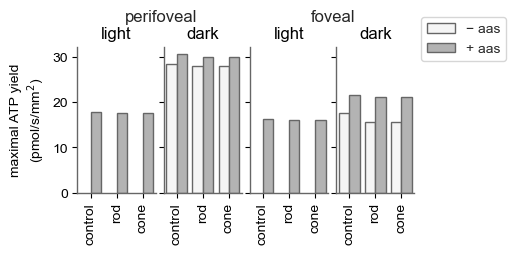

In [22]:
my_palette = {'+ aas': (0.7,0.7,0.7), '− aas': (0.96,0.96,0.96)}

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 
results_long1 = results_long1[results_long1['single/combined'].isin(['combined'])]

cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)

# change order aas no aas
aa_order = ['0.0','1.0']
results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories = aa_order, ordered = True)

# replace 0.0 to '− aas' and 1.0 to '+ aas'
results_long1['aa_ratio'] = results_long1['aa_ratio'].replace({'0.0':'− aas', '1.0':'+ aas'})

g = sns.catplot(data=results_long1, x='cell', \
            y='maximal ATP yield (pmol/s/mm^2)',\
            kind='bar', \
            hue='aa_ratio',\
            col = 'light/dark_region',\
            ci='sd',\
            palette = my_palette, legend=False)

set_figure_width(1,.51)  # For one column
dg_axes()

# CHANGE X tick labels
for ax in plt.gcf().axes:
    ax.set_xticklabels(['control','rod','cone'], rotation=90)
    ax.set_xlabel('')  # REMOVE x axis title
    ax.set_ylabel('maximal ATP yield\n(pmol/s/mm$^2$)')

# change titles of subplots
titles = ['light', 'dark','light','dark']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# plt txt above first two subtiles
plt.gcf().text(0.27, 1.1, 'perifoveal', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.76, 1.1, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row

plt.subplots_adjust(hspace = 0.4) # increase space between rows
plt.subplots_adjust(wspace = 0.1) # increase space between columns

# remove all legends
for ax in plt.gcf().axes:
    ax.legend().remove()
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(4.3, 1.25), ncol=1)

# save figure in results folder in user folder
results_folder = create_folder('results','paper','blood_exchange_bounds')
plt.savefig(results_folder + '/ATP_FBA_aas_noaas_combined_foveal_perifoveal.png', dpi=600, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\1943586012.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=results_long1, x='cell', \


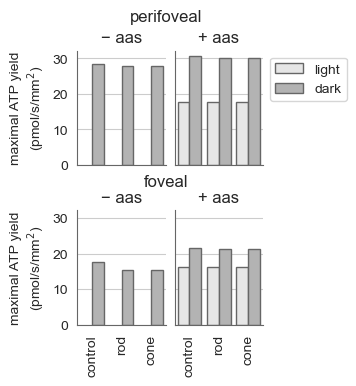

In [23]:
# create a barplot
# change order 
# define the palette with grey and white colors
import seaborn as sns
import matplotlib.pyplot as plt

my_palette = {'dark': (0.7,0.7,0.7), 'light': (0.9,0.9,0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 
results_long1 = results_long1[results_long1['single/combined'].isin(['combined'])]

cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)

# change order aas no aas
aa_order = ['0.0','1.0']
results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories = aa_order, ordered = True)

# replace 0.0 to '− aas' and 1.0 to '+ aas'
results_long1['aa_ratio'] = results_long1['aa_ratio'].replace({'0.0':'− aas', '1.0':'+ aas'})

# set whitegrid style
sns.set_style("whitegrid")

g = sns.catplot(data=results_long1, x='cell', \
            y='maximal ATP yield (pmol/s/mm^2)',\
            row='region',\
            kind='bar', \
            hue='light/dark',\
            col = 'aa_ratio',\
            ci='sd',\
            palette = my_palette, legend=False)

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')

plt.gcf().set_size_inches(2,3)

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('maximal ATP yield\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# CHANGE X tick labels
for ax in plt.gcf().axes:
    ax.set_xticklabels(['control','rod','cone'], rotation=90)

# change titles of subplots
titles = ['− aas', '+ aas','− aas','+ aas']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)
    
# create text above first row
plt.gcf().text(0.5, 1.08, 'perifoveal', ha='center', va='center', fontsize = 12)
# create text above second row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12)

# move legend to the right
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[2].legend().remove()
plt.gcf().axes[3].legend().remove()
plt.gcf().axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# increase space between plots
plt.subplots_adjust(wspace = 0.1)
# increase space between rows
plt.subplots_adjust(hspace = 0.4)

# create results folder
# save figure in results folder in user folder
plt.savefig(results_folder + '/ATP_FBA_aas_noaas_combined_foveal_perifoveal2.png', dpi=600, bbox_inches='tight')

In [24]:
#########################################################################################
########################## FOVEAL CONE / perifoveal ROD #################################
#########################################################################################

# from results_long2 select all entries for RPE-PR cone that have region foveal and for RPE-PR rod that have region perifoveal, and all control models
results_long2 = results_long[(results_long['cell'].isin(['RPE - PR cone']) & results_long['region'].isin(['foveal']))\
                              | (results_long['cell'].isin(['RPE - PR rod']) & results_long['region'].isin(['perifoveal']))\
                                | (results_long['cell'].isin(['RPE - PR control']))]

# make one new column in which cell + region are combined
results_long2['cell_region'] = results_long2['cell'] + ' ' + results_long2['region']

results_long2

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\1198633315.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long2['cell_region'] = results_long2['cell'] + ' ' + results_long2['region']


,model,light/dark_region,maximal ATP yield (pmol/s/mm^2),single/combined,aa_ratio,cell,region,light/dark,cell_region
5,mod_RPE_PRcontrol2.0,light_perifoveal,18.415882,combined,2.0,RPE - PR control,perifoveal,light,RPE - PR control perifoveal
6,mod_RPE_PRcontrol1.0,light_perifoveal,17.808396,combined,1.0,RPE - PR control,perifoveal,light,RPE - PR control perifoveal
7,mod_RPE_PRcontrol0.5,light_perifoveal,16.935432,combined,0.5,RPE - PR control,perifoveal,light,RPE - PR control perifoveal
8,mod_RPE_PRcontrol0.25,light_perifoveal,9.699103,combined,.25,RPE - PR control,perifoveal,light,RPE - PR control perifoveal
9,mod_RPE_PRcontrol0.0,light_perifoveal,NaN,combined,0.0,RPE - PR control,perifoveal,light,RPE - PR control perifoveal
...,...,...,...,...,...,...,...,...,...
170,mod_RPE_PRcontrol2.0,dark_foveal,22.379329,combined,2.0,RPE - PR control,foveal,dark,RPE - PR control foveal
171,mod_RPE_PRcontrol1.0,dark_foveal,21.612051,combined,1.0,RPE - PR control,foveal,dark,RPE - PR control foveal
172,mod_RPE_PRcontrol0.5,dark_foveal,21.228412,combined,0.5,RPE - PR control,foveal,dark,RPE - PR control foveal
173,mod_RPE_PRcontrol0.25,dark_foveal,21.012995,combined,.25,RPE - PR control,foveal,dark,RPE - PR control foveal


C:\Users\prins\AppData\Local\Temp\ipykernel_8836\3355220269.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories=aa_order, ordered=True)
C:\Users\prins\AppData\Local\Temp\ipykernel_8836\3355220269.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)
C:\Users\prins\AppData\Local\Temp\ipykernel_8836\3355220269.py:17: FutureWarni

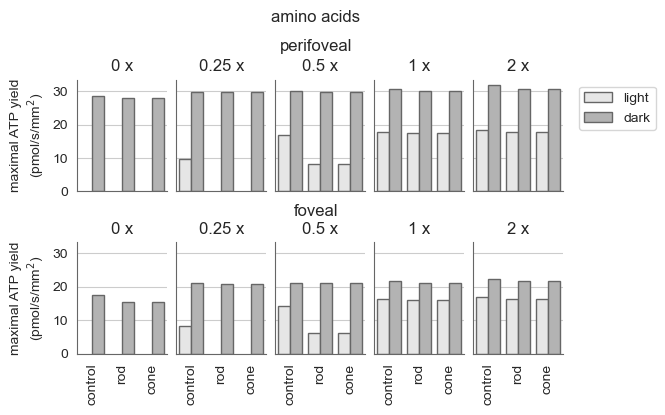

In [25]:
# create a barplot
# change order 
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)


# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['single/combined'].isin(['combined'])]
cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
aa_order = ['0.0','.25','0.5','1.0','2.0']
# convert aa_ratio column to categorical variable with desired order
results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories=aa_order, ordered=True)
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)


g = sns.catplot(data=results_long1, x='cell', \
            y='maximal ATP yield (pmol/s/mm^2)',\
            hue='light/dark',\
            kind='bar', \
            col='aa_ratio',\
            row = 'region',\
            ci='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)

plt.gcf().set_size_inches(5,3)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('maximal ATP yield\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# titles
plt.suptitle('amino acids', y = 1.2)
plt.gcf().text(0.5, 1.08, 'perifoveal', ha='center', va='center', fontsize = 12) # create text above first row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row

# titles subplots
titles = ['0 x', '0.25 x', '0.5 x','1 x','2 x',\
          '0 x', '0.25 x', '0.5 x','1 x','2 x']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots for all axes
for ax in plt.gcf().axes:
    ax.legend().remove()

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    
# CHANGE X tick labels
plt.gcf().axes[1].set_xticklabels(['control','rod','cone'])

plt.subplots_adjust(wspace = 0.1) # increase space between plots
plt.subplots_adjust(hspace = 0.45) # increase space between rows

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(5.5, 1.0))

# make dpi 100 in display
plt.gcf().set_dpi(100)

# save figure in results folder in user folder
plt.savefig(results_folder +  '/ATP_FBA_levels_aas_foveal_perifoveal.png', dpi=600, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\2949961192.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.catplot(data=results_long1, x='cell', \


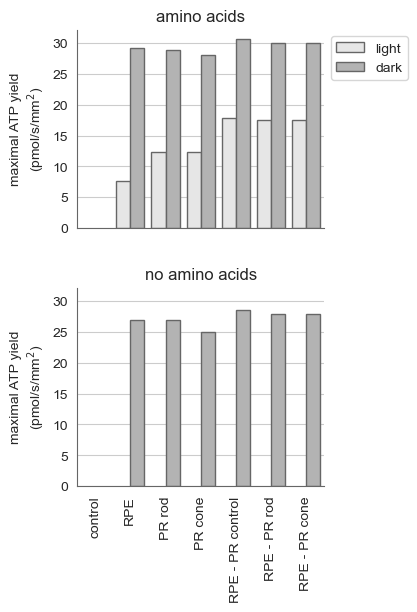

In [26]:
# create a barplot
# change order 

# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long['cell'] = pd.Categorical(results_long['cell'], categories=cell_order, ordered=True)


# select only rows with 1.0 or 0.0 in aa_ratio column perifoveal only
results_long1 = results_long[results_long['region'].isin(['perifoveal'])]
results_long1 = results_long1[results_long1['aa_ratio'].isin(['1.0','0.0'])] 

sns.catplot(data=results_long1, x='cell', \
            y='maximal ATP yield (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='aa_ratio',\
            ci='sd',\
            palette=my_palette, \
            legend=False)

plt.xticks(rotation=90)
plt.gcf().set_size_inches(3,5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('maximal ATP yield\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['amino acids', 'no amino acids']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[1].legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# save figure in results folder in user folder
plt.savefig(results_folder +  '/ATP_FBA_aas_noaas_all.png', dpi=600, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\1835039076.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=results_long1, x='cell', \


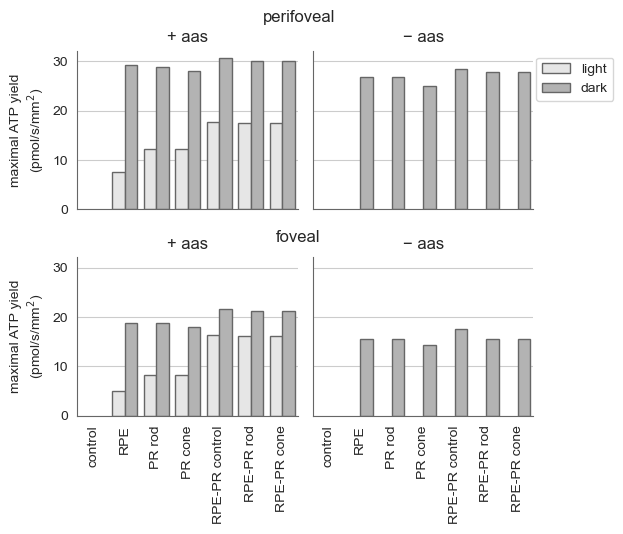

In [27]:
# create a barplot
# change order 
# whitegrid
sns.set_style("whitegrid")

# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long['cell'] = pd.Categorical(results_long['cell'], categories=cell_order, ordered=True)

# select only rows with 1.0 or 0.0 in aa_ratio column perifoveal only
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 

g = sns.catplot(data=results_long1, x='cell', \
            y='maximal ATP yield (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='region',\
            col = 'aa_ratio',\
            ci='sd',\
            palette=my_palette, \
            legend=False)

plt.xticks(rotation=90)
plt.gcf().set_size_inches(5,4)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('maximal ATP yield\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# change titles of subplots
titles = ['+ aas', '− aas','+ aas', '− aas']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

# set xticklabels
plt.gcf().axes[0].set_xticklabels(['control','RPE','PR rod','PR cone','RPE-PR control','RPE-PR rod','RPE-PR cone'])
    
# Remove all legends from both subplots
for ax in plt.gcf().axes:
    ax.legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(2.05, 1.0))

plt.gcf().text(0.5, 1.05, 'perifoveal', ha='center', va='center', fontsize = 12) # create text above first row
plt.gcf().text(0.5, 0.5, 'foveal', ha='center', va='center', fontsize = 12) # create text above second row

plt.subplots_adjust(hspace = 0.35)
plt.subplots_adjust(hspace = 0.3)

# save figure in results folder in user folder
plt.savefig(results_folder +  '/ATP_FBA_aas_noaas_all_foveal_perifoveal.png', dpi=600, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\2017820675.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g=sns.catplot(data=results_long2, x='cell', \


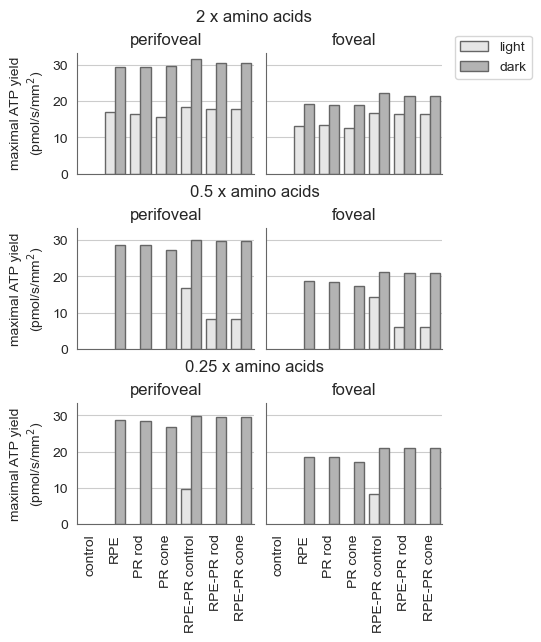

In [28]:
# create a barplot
# change order 
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long2 = results_long[results_long['aa_ratio'].isin(['2.0','0.5','.25'])] 

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']

g=sns.catplot(data=results_long2, x='cell', \
            y='maximal ATP yield (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='aa_ratio',\
            col = 'region',\
            ci='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.gcf().set_size_inches(4,5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('maximal ATP yield\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['perifoveal', 'foveal','perifoveal', 'foveal','perifoveal', 'foveal']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

plt.gcf().text(0.5, 1.05, '2 x amino acids', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.5, 0.7, '0.5 x amino acids', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.5, 0.35, '0.25 x amino acids', ha='center', va='center', fontsize = 12)

# increase space between rows
plt.subplots_adjust(hspace = 0.45)

# Remove legends from both subplots
for ax in plt.gcf().axes:
    ax.legend().remove()

    # rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

# add xtick labels
plt.gcf().axes[1].set_xticklabels(['control','RPE','PR rod','PR cone','RPE-PR control','RPE-PR rod','RPE-PR cone'])

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(2.1, 1.2))

# save figure in results folder in user folder
plt.savefig(results_folder + '/ATP_FBA_aas.png', dpi=600, bbox_inches='tight')

In [29]:
def my_range(start, end, step):
    return [round(start + i * step, 1) for i in range(int((end - start) / step) + 1)]

In [30]:
# # uncomment to run again (takes ~ 60 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(2.5,6,0.1)
# multiplication_factors_dark = my_range(7,15,0.1)

# # light
# # lactate_RPE_light = 3.79
# # lactate_PR_light = 0.41
# # lactate_RPEp_light = lactate_RPE_light/(lactate_RPE_light+lactate_PR_light)
# # lactate_PRp_light = lactate_PR_light/(lactate_RPE_light+lactate_PR_light)
# # dark
# # lactate_RPE_dark = 7.18
# # lactate_PR_dark = 1.16
# # lactate_RPEp_dark = lactate_RPE_dark/(lactate_RPE_dark+lactate_PR_dark)
# # lactate_PRp_dark = lactate_PR_dark/(lactate_RPE_dark+lactate_PR_dark)

# lactate_RPEp_light, lactate_PRp_light =  get_lactate_proportions(ex_bounds_light_perifoveal)
# lactate_PRp_dark, lactate_RPEp_dark =  get_lactate_proportions(ex_bounds_dark_perifoveal)

# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################
#         b = ex_bounds_light_perifoveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b, 'RPE'), 'RPE')
#         m = open_blood_exchange(m,blood_ratio0,  get_gluc(b, 'PR'), 'PR')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds
#         for i in multiplication_factors_light:

#             lactate_RPE = lactate_RPEp_light*i
#             lactate_PR = lactate_PRp_light*i

#             # set exchange bounds for lactate
#             m.reactions.get_by_id(lactate_ID +'_RPE').bounds = (lactate_RPE,lactate_RPE)
#             m.reactions.get_by_id(lactate_ID +'_PR').bounds = (lactate_PR, lactate_PR)
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

        
#         m = open_blood_exchange(m,blood_ratio, get_gluc(b, 'RPE'), 'RPE')
#         m = open_blood_exchange(m,blood_ratio,  get_gluc(b, 'PR'), 'PR')

#         for i in multiplication_factors_light:
#             lactate_RPE = lactate_RPEp_light*i
#             lactate_PR = lactate_PRp_light*i
#             # set exchange bounds for lactate
#             m.reactions.get_by_id(lactate_ID +'_RPE').bounds = (lactate_RPE,lactate_RPE)
#             m.reactions.get_by_id(lactate_ID +'_PR').bounds = (lactate_PR, lactate_PR)
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################
 
#         b = ex_bounds_dark_perifoveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b, 'RPE'), 'RPE') 
#         m = open_blood_exchange(m,blood_ratio0,  get_gluc(b, 'PR'), 'PR')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds

#         for i in multiplication_factors_dark:
           
#             # set exchange bounds for lactate
#             m.reactions.get_by_id(lactate_ID + '_RPE').bounds = (lactate_RPEp_dark*i,lactate_RPEp_dark*i)
#             m.reactions.get_by_id(lactate_ID + '_PR').bounds = (lactate_PRp_dark*i, lactate_PRp_dark*i)          

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#         # with aas
#         m = open_blood_exchange(m,blood_ratio, get_gluc(b, 'RPE'), 'RPE')
#         m = open_blood_exchange(m,blood_ratio, get_gluc(b, 'PR'), 'PR')
        
#         for i in multiplication_factors_dark:

#             # set exchange bounds for lactate
#             m.reactions.get_by_id(lactate_ID + '_RPE').bounds = (lactate_RPEp_dark*i,lactate_RPEp_dark*i)
#             m.reactions.get_by_id(lactate_ID + '_PR').bounds = (lactate_PRp_dark*i, lactate_PRp_dark*i)   
    
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas.to_pickle(pickle_folder + '/df_light_no_aas.pkl')
# df_light_aas.to_pickle(pickle_folder + '/df_light_aas.pkl')
# df_dark_no_aas.to_pickle(pickle_folder + '/df_dark_no_aas.pkl')
# df_dark_aas.to_pickle(pickle_folder + '/df_dark_aas.pkl')

In [31]:
# # # uncomment to run again (takes ~ 80 min)
# # ####################################################################################################
# # ###########                                   FOVEAL                                   #############
# # ####################################################################################################


# # ####################################################################################################
# # ###########                                LACTATE SWEEPS                              #############
# # ###########                                 LIGHT / DARK                               #############
# # ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# # ####################################################################################################


# multiplication_factors_light = my_range(0,4.5,0.1)
# multiplication_factors_dark = my_range(0,9,0.1)

# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in combined_models:
    
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################
#         b = ex_bounds_light_foveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,'RPE'), 'RPE')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds

#         for i in multiplication_factors_light:
#             m.reactions.get_by_id(lactate_ID + '_RPE').bounds = (i,i)
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,'RPE'), 'RPE')
        
#         for i in multiplication_factors_light:
#             m.reactions.get_by_id(lactate_ID + '_RPE').bounds = (i,i)
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################
#         b = ex_bounds_dark_foveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,'RPE'), 'RPE') 
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex]
#         for i in multiplication_factors_dark:
#             m.reactions.get_by_id(lactate_ID + '_RPE').bounds = (i,i)
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,'RPE'), 'RPE')
#         for i in multiplication_factors_dark:
#             m.reactions.get_by_id(lactate_ID + '_RPE').bounds = (i,i)
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]
            
#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas_foveal.to_pickle(pickle_folder + '/df_light_no_aas_foveal.pkl')
# df_light_aas_foveal.to_pickle(pickle_folder + '/df_light_aas_foveal.pkl')
# df_dark_no_aas_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_foveal.pkl')
# df_dark_aas_foveal.to_pickle(pickle_folder + '/df_dark_aas_foveal.pkl')

Make sweep figures

In [32]:
# import MultipleLocator
from matplotlib.ticker import MultipleLocator

PERIFOVEAL


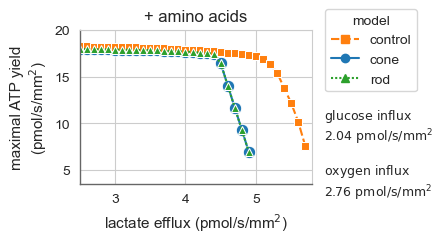

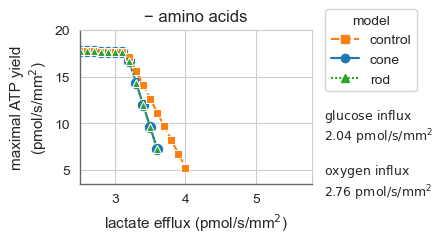

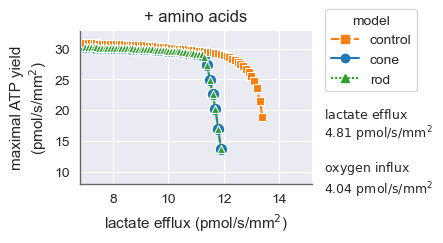

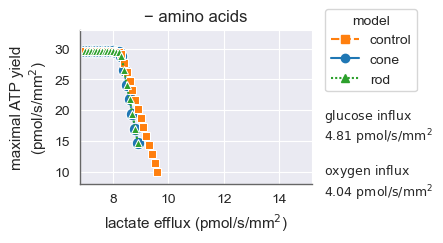

In [33]:
# CONFIGURATIONS COMBINED MODEL FIGS
def set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal=''):

    dg_axes()
    if glucose_lactate == 'glucose':
        influx_efflux_text = " influx"
    elif glucose_lactate == 'lactate':
        influx_efflux_text = " efflux"
    else:
        return "Invalid parameter type"
    plt.xlabel(glucose_lactate + influx_efflux_text +' (pmol/s/mm$^2$)',fontsize=11)

    #change marker size
    ax.lines[0].set_markersize(9)
    ax.lines[1].set_markersize(6)
    ax.lines[2].set_markersize(6)

    plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
    plt.gcf().text(0.52, 1.02, foveal_perifoveal, ha='center', va='center', fontsize = 12)

    # change labels of legend
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[0], handles[2]]
    labels = ['control', 'cone', 'rod']

    ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.48, 1.1800))

    
def add_textbox_bounds(glucose_lactate=('glucose', 2.04), oxygen_level=2.76):
    """
    Adds a textbox to a given matplotlib figure and axis with information
    about glucose/lactate influx or efflux and oxygen level.

    Parameters:
        glucose_lactate: tuple, first element is either 'glucose' or 'lactate', second element is the value
        oxygen_level: float, the value of the oxygen level

    """
    param_type, param_value = glucose_lactate
    
    if param_type == 'glucose':
        influx_efflux_text = "influx"
    elif param_type == 'lactate':
        influx_efflux_text = "efflux"
    else:
        return "Invalid parameter type"

    textstr = '\n'.join((
        rf'$\mathrm{{{param_type}\ {influx_efflux_text}}}$',
        rf'${param_value}\ \mathrm{{pmol/s/mm}}^2$',
        '',
        r'$\mathrm{oxygen\ influx}$',
        rf'${oxygen_level}\ \mathrm{{pmol/s/mm}}^2$'
    ))

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

    
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     TEST                                   #############
####################################################################################################
results_folder = create_folder('results', 'paper','sweep', 'lactate')

pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas = pd.read_pickle(pickle_folder +  '/df_light_no_aas.pkl')
df_light_aas = pd.read_pickle(pickle_folder +  '/df_light_aas.pkl')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')

print('PERIFOVEAL')
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_aas,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 2.04), 2.76)
fig.savefig(results_folder + '//small_light_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_no_aas,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 2.04), 2.76)
fig.savefig(results_folder + '//small_light_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_aas,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(8,33)
ax.set_xlim(6.8,15.2)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('lactate', 4.81), 4.04)
fig.savefig(results_folder + '//small_dark_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_no_aas,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(8,33)
ax.set_xlim(6.8,15.2)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 4.81), 4.04)
fig.savefig(results_folder + '//small_dark_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)


FOVEAL


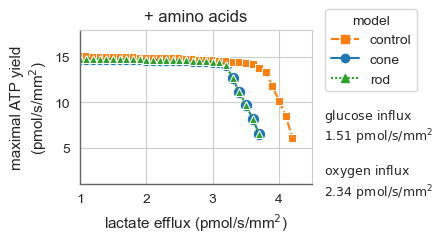

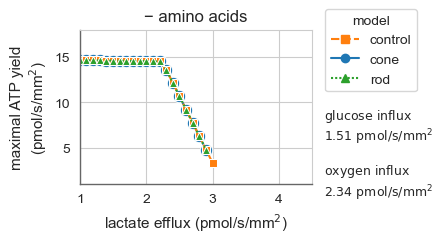

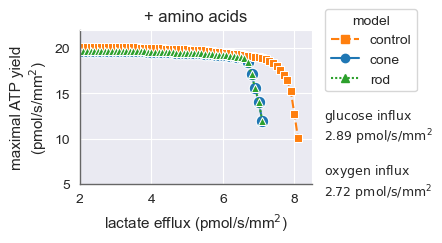

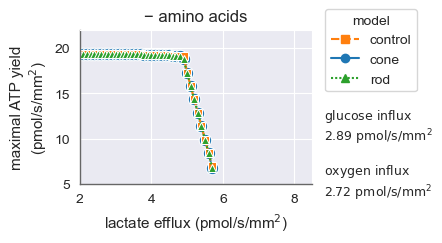

In [34]:
# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_foveal.pkl')
df_light_aas_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_foveal.pkl')
df_dark_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_foveal.pkl')
df_dark_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_foveal.pkl')

print('FOVEAL')
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_aas_foveal,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(1,18)
ax.set_xlim(1,4.5)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose',1.51), 2.34)
fig.savefig(results_folder + '//small_light_no_aas_lactate_sweep_foveal.png', bbox_inches='tight',dpi=600)

fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_no_aas_foveal,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(1,18)
ax.set_xlim(1,4.5)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 1.51), 2.34)
fig.savefig(results_folder + '//small_light_aas_lactate_sweep_foveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_aas_foveal,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(5,22)
ax.set_xlim(2,8.5)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 2.89), 2.72)
fig.savefig(results_folder + '//small_dark_no_aas_lactate_sweep_foveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_no_aas_foveal,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(5,22)
ax.set_xlim(2,8.5)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 2.89), 2.72)
fig.savefig(results_folder + '//small_dark_aas_lactate_sweep_foveal.png', bbox_inches='tight',dpi=600)


PERIFOVEAL


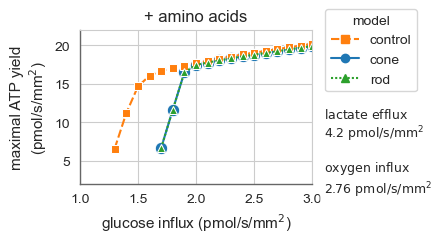

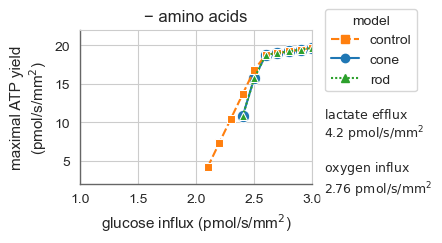

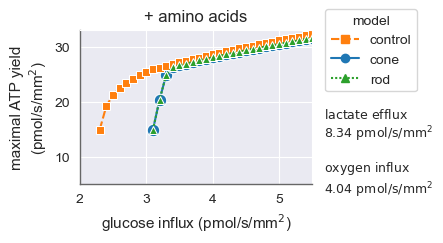

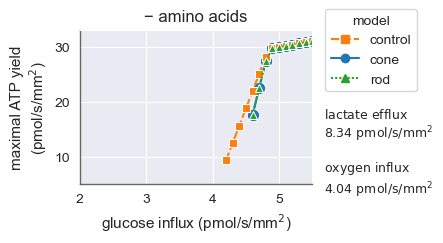

In [35]:
   
####################################################################################################
###########                                GLUCOSE SWEEPS                              #############
###########                                     TEST                                   #############
####################################################################################################
results_folder = create_folder('results', 'paper','sweep', 'glucose')

pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose = pd.read_pickle(pickle_folder +  '/df_light_no_aas_glucose.pkl')
df_light_aas_glucose = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose.pkl')
df_dark_no_aas_glucose = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose.pkl')
df_dark_aas_glucose = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose.pkl')

print('PERIFOVEAL')
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_aas_glucose,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(2,22)
ax.set_xlim(1,3)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate', 4.20), 2.76)
fig.savefig(results_folder + '//small_light_no_aas_glucose_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_no_aas_glucose,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(2,22)
ax.set_xlim(1,3)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate',  4.20), 2.76)
fig.savefig(results_folder + '//small_light_aas_glucose_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_aas_glucose,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(5,33)
ax.set_xlim(2,5.5)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate', 8.34), 4.04)
fig.savefig(results_folder + '//small_dark_no_aas_glucose_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_no_aas_glucose,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(5,33)
ax.set_xlim(2,5.5)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate', 8.34), 4.04)
fig.savefig(results_folder + '//small_dark_aas_glucose_sweep_perifoveal.png', bbox_inches='tight',dpi=600)


FOVEAL


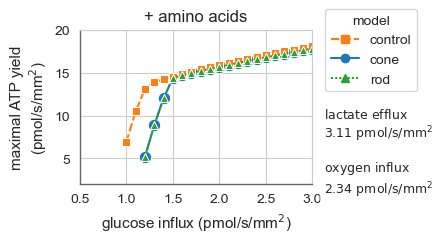

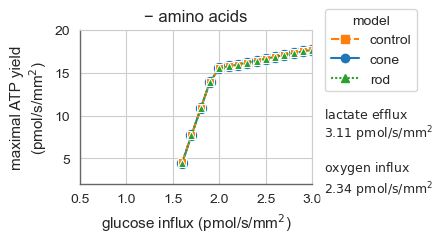

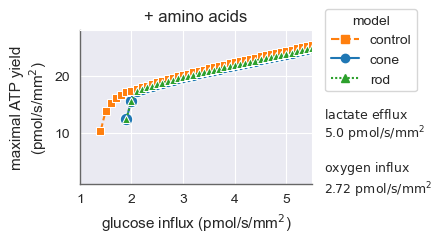

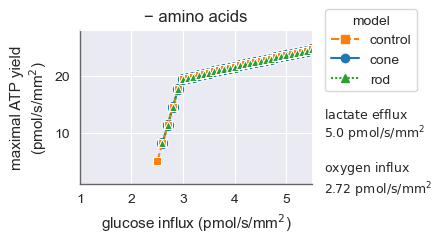

In [36]:
   
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     TEST                                   #############
####################################################################################################
results_folder = create_folder('results', 'paper','sweep', 'glucose')

pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_glucose_foveal.pkl')
df_light_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_foveal.pkl')
df_dark_no_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_foveal.pkl')
df_dark_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_foveal.pkl')

print('FOVEAL')
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(2,20)
ax.set_xlim(.5,3)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate', 3.11), 2.34)
fig.savefig(results_folder + '//small_light_no_aas_glucose_sweep_foveal.png', bbox_inches='tight',dpi=600)

fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_no_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(2,20)
ax.set_xlim(.5,3)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate', 3.11), 2.34)
fig.savefig(results_folder + '//small_light_aas_glucose_sweep_foveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(1,28)
ax.set_xlim(1,5.5)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate', 5.00), 2.72)
fig.savefig(results_folder + '//small_dark_no_aas_glucose_sweep_foveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_no_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(1,28)
ax.set_xlim(1,5.5)
set_combined_fig_configurations(glucose_lactate='glucose',foveal_perifoveal='')
add_textbox_bounds(('lactate',5.00), 2.72)
fig.savefig(results_folder + '//small_dark_aas_glucose_sweep_foveal', bbox_inches='tight',dpi=600)


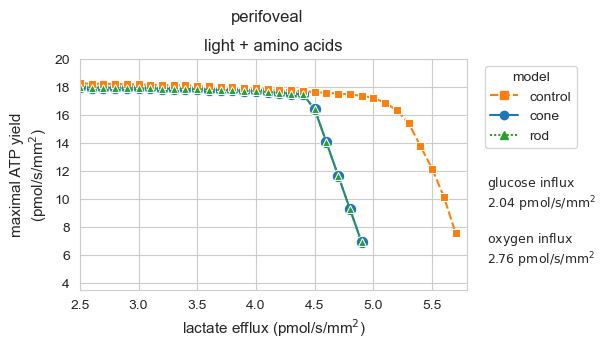

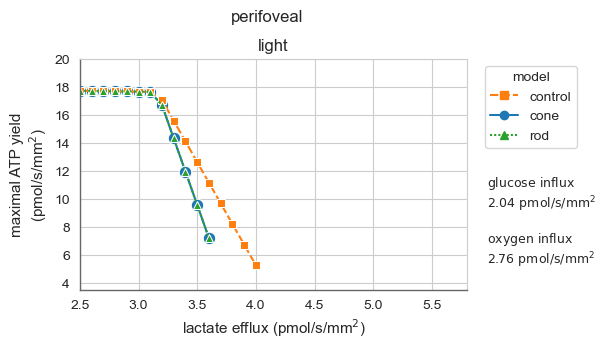

In [37]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                  perifoveal                                #############
####################################################################################################


# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas = pd.read_pickle(pickle_folder +  '/df_light_no_aas.pkl')
df_light_aas = pd.read_pickle(pickle_folder +  '/df_light_aas.pkl')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# LACTATE SWEEP FIGURES LIGHT

# import plt
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas,markers=['o','s','^'],ax=ax)

#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)
df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep_perifoveal.xlsx')  


# LACTATE SWEEP

# import plt
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)
df_light_no_aas.to_excel(results_folder + '/light_no_aas_lactate_sweep_perifoveal.xlsx')  

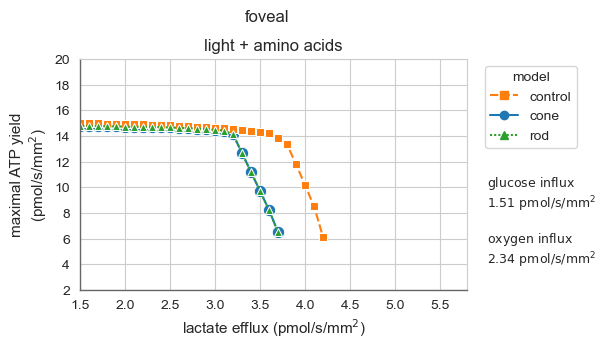

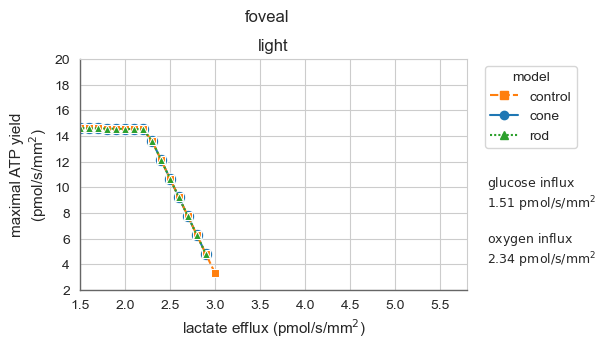

In [38]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                  FOVEAL                                   #############
####################################################################################################

# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_foveal.pkl')
df_light_aas_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_foveal.pkl')
df_dark_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_foveal.pkl')
df_dark_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(2,20)
ax.set_xlim(1.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$1.51\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.34\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_lactate_sweep_foveal.xlsx')  

# LACTATE SWEEP

# import plt
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(2,20)
ax.set_xlim(1.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_lactate_sweep_foveal.xlsx')  


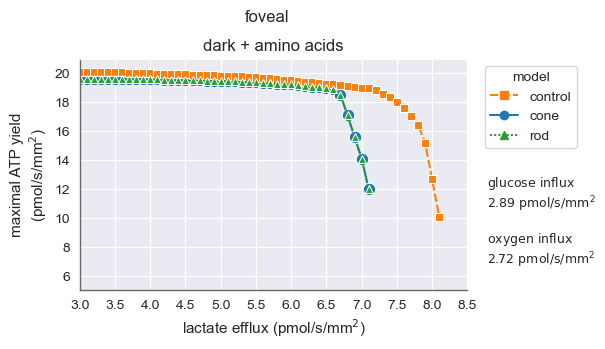

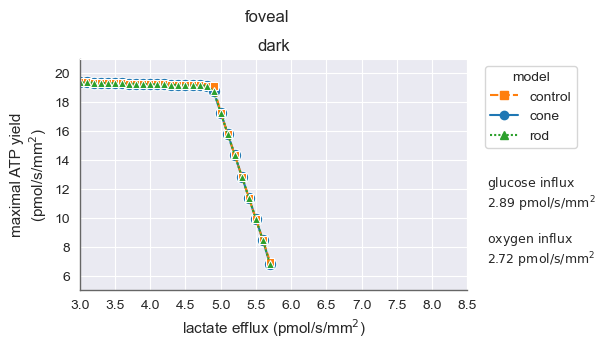

In [39]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     DARK                                   #############
###########                                    FOVEAL                                  #############
####################################################################################################
# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_dark_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_foveal.pkl')
df_dark_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# LACTATE SWEEP FIGURES LIGHT
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(5,21)
ax.set_xlim(3,8.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.89\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.72\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_aas_lactate_sweep_foveal.xlsx')  


# LACTATE SWEEP

# import plt
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(5,21)
ax.set_xlim(3,8.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_dark_no_aas_foveal.to_excel(results_folder + '/dark_no_aas_lactate_sweep_foveal.xlsx')  

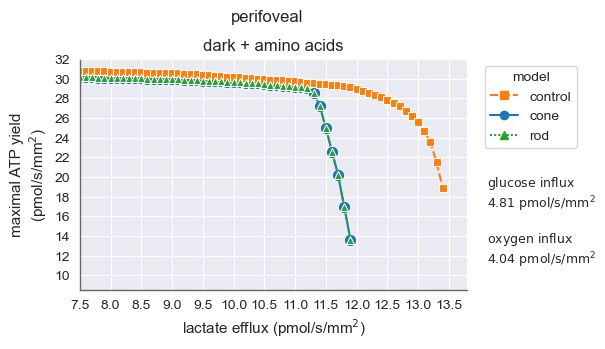

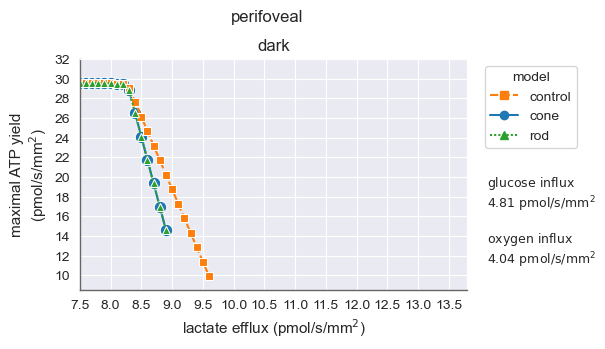

In [40]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     DARK                                   #############
###########                                  perifoveal                                #############
####################################################################################################


# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# LACTATE SWEEP FIGURES LIGHT
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(8.5,32)
ax.set_xlim(7.5,13.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$4.81\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_aas_lactate_sweep_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_aas_lactate_sweep_perifoveal.xlsx')  

# LACTATE SWEEP
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(8.5,32)
ax.set_xlim(7.5,13.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight')
df_dark_no_aas.to_excel(results_folder + '/dark_no_aas_lactate_sweep_perifoveal.xlsx')  

In [41]:
# # # ####################################################################################################
# # # ##########                                      FOVEAL                                   ###########  
# # # ####################################################################################################

# # # ####################################################################################################
# # # ###########                                GLUCOSE SWEEPS                              #############
# # # ###########                                 LIGHT / DARK                               #############
# # # ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# # # ####################################################################################################

# # # MAR09048: oxygen 
# # # MAR09034: glucose 
# # # MAR09135: lactate 


# multiplication_factors_light = my_range(0,8,0.1)
# multiplication_factors_dark = my_range(0,10,0.1)

# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         ################ LIGHT ################
#         b = ex_bounds_light_foveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,'RPE'), 'RPE')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds

#         for i in multiplication_factors_light:
#             m.reactions.get_by_id(glucose_ID + '_RPE').bounds = (-i,-i)
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,'RPE'), 'RPE')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds
        
#         for i in multiplication_factors_light:
#             m.reactions.get_by_id(glucose_ID + '_RPE').bounds = (-i,-i)
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################
#         b = ex_bounds_dark_foveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,'RPE'), 'RPE')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds

#         for i in multiplication_factors_dark:
#             m.reactions.get_by_id(glucose_ID + '_RPE').bounds = (-i,-i)
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,'RPE'), 'RPE')
#         for ex in b.keys(): 
#             m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds
            
#         for i in multiplication_factors_dark:
#             m.reactions.get_by_id(glucose_ID + '_RPE').bounds = (-i,-i) 
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas


# df_light_no_aas_glucose_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_glucose_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_glucose_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_glucose_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # pickle df_light_no_aas_glucose, df_light_aas_glucose, df_dark_no_aas_glucose, df_dark_aas_glucose
# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
# df_light_no_aas_glucose_foveal.to_pickle(pickle_folder + '/df_light_no_aas_glucose_foveal.pkl')
# df_light_aas_glucose_foveal.to_pickle(pickle_folder +'/df_light_aas_glucose_foveal.pkl')
# df_dark_no_aas_glucose_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_foveal.pkl')
# df_dark_aas_glucose_foveal.to_pickle(pickle_folder +'/df_dark_aas_glucose_foveal.pkl')

In [42]:
# load pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose = pd.read_pickle(pickle_folder +  '/df_light_no_aas_glucose.pkl')
df_light_aas_glucose = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose.pkl')
df_dark_no_aas_glucose = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose.pkl')
df_dark_aas_glucose = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose.pkl')

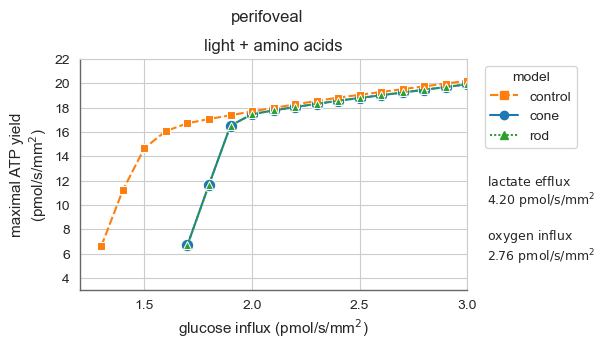

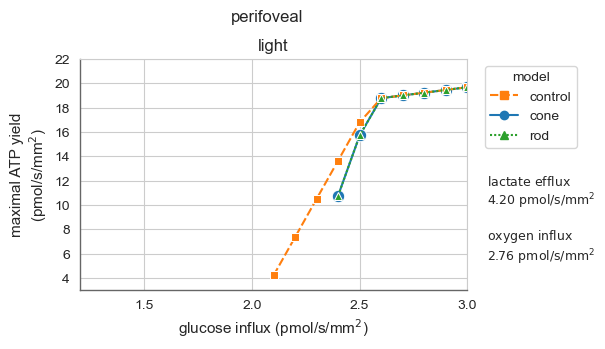

In [43]:
##############################################################
#######        perifoveal GLUCOSE SWEEP FIGURES        ########
##############################################################

results_folder = create_folder('results', 'paper','sweep', 'glucose')

# GLUCOSE SWEEP FIGURES LIGHT
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(3,22)
ax.set_xlim(1.2,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$4.20\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_glucose_sweep_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_glucose_sweep_perifoveal.xlsx')  

# GLUCOSE SWEEP

fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(3,22)
ax.set_xlim(1.2,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_perifoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_glucose_sweep_perifoveal.xlsx')  



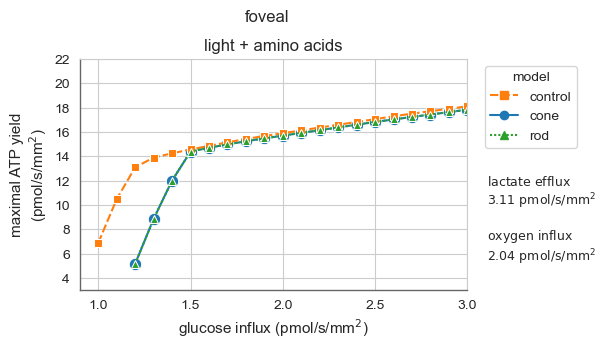

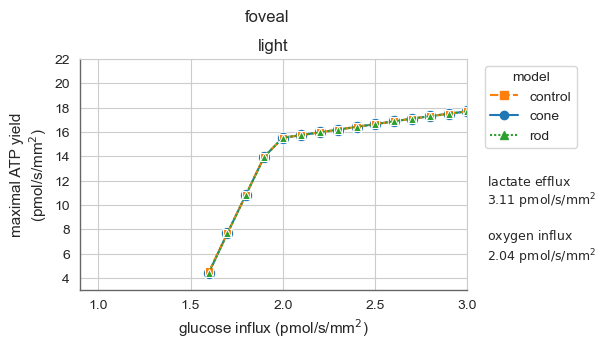

In [44]:
##############################################################
#######           FOVEAL GLUCOSE SWEEP FIGURES        ########
##############################################################

# load pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_glucose_foveal.pkl')
df_light_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_foveal.pkl')
df_dark_no_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_foveal.pkl')
df_dark_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_foveal.pkl')
results_folder = create_folder('results', 'paper','sweep', 'glucose')

# GLUCOSE SWEEP FIGURES LIGHT
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(3,22)
ax.set_xlim(.9,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$3.11\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_glucose_sweep_foveal.xlsx')  

# GLUCOSE SWEEP
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(3,22)
ax.set_xlim(.9,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_glucose_sweep_foveal.xlsx')  



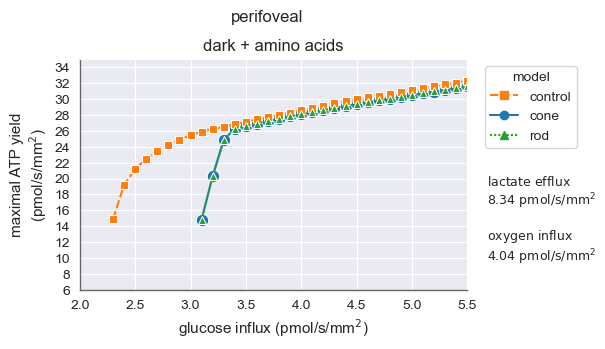

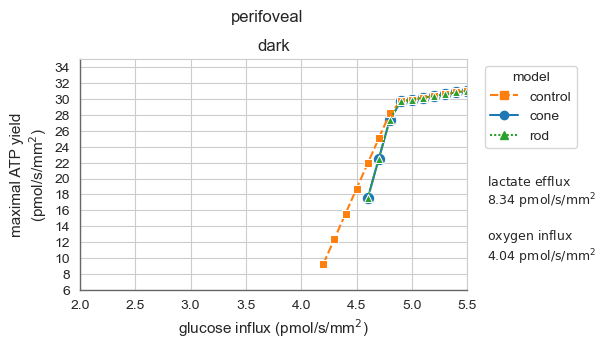

In [45]:
##############################################################
#######    perifoveal DARK GLUCOSE SWEEP FIGURES      ########
##############################################################


# GLUCOSE SWEEP FIGURES DARK
results_folder = create_folder('results', 'paper','sweep', 'glucose')

# import plt
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(6,35)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$8.34\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_glucose_sweep.png', bbox_inches='tight')
df_dark_aas_glucose.to_excel(results_folder + '/dark_aas_glucose_sweep.xlsx')  

# GLUCOSE SWEEP
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(6,35)
ax.set_xlim(2,5.5)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_perifoveal.png', bbox_inches='tight')
df_dark_no_aas_glucose.to_excel(results_folder + '/dark_no_aas_glucose_sweep_perifoveal.xlsx')  


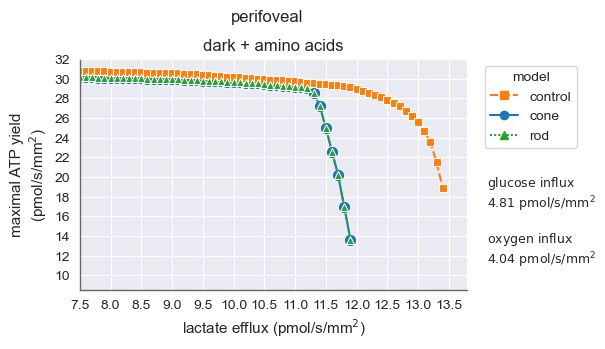

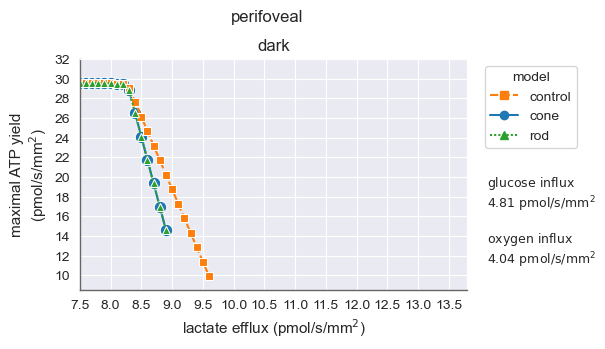

In [46]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     DARK                                   #############
###########                                  perifoveal                                #############
####################################################################################################


# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')


# LACTATE SWEEP FIGURES LIGHT
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(data=df_dark_aas,markers=['o','s','^'],ax=ax)

#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(8.5,32)
ax.set_xlim(7.5,13.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$4.81\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_aas_lactate_sweep_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_aas_lactate_sweep_perifoveal.xlsx')  


# LACTATE SWEEP
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(8.5,32)
ax.set_xlim(7.5,13.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight')
df_dark_no_aas.to_excel(results_folder + '/dark_no_aas_lactate_sweep_perifoveal.xlsx')  

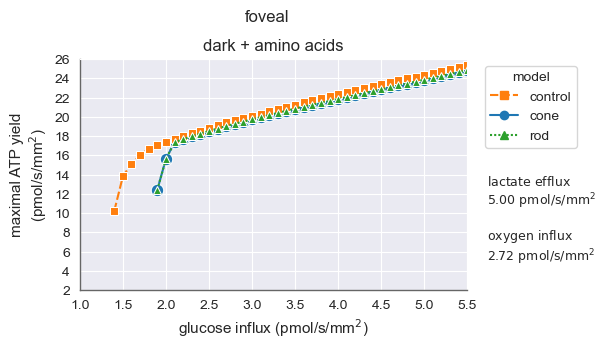

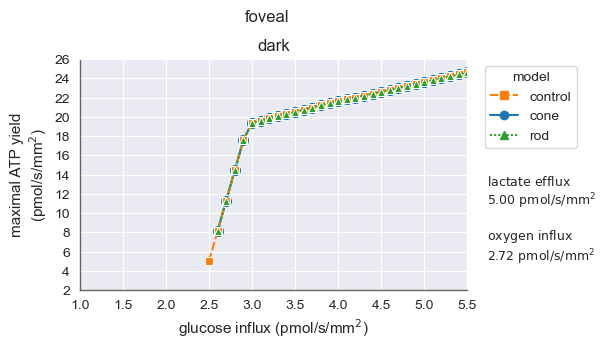

In [47]:
##############################################################
#######        FOVEAL DARK GLUCOSE SWEEP FIGURES      ########
##############################################################

# GLUCOSE SWEEP FIGURES DARK
results_folder = create_folder('results', 'paper','sweep', 'glucose')

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(2,26)
ax.set_xlim(1,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$5.00\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.72\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_dark_aas_glucose_foveal.to_excel(results_folder + '/dark_aas_glucose_sweep_foveal.xlsx')  

# GLUCOSE SWEEP
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(2,26)
ax.set_xlim(1,5.5)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_dark_no_aas_glucose_foveal.to_excel(results_folder + '/dark_no_aas_glucose_sweep_foveal.xlsx')  

In [48]:
orange =  (1.0, 0.4980392156862745, 0.054901960784313725)
blue =  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
green =  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
red = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
purple = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)



In [49]:
def set_rxn_bounds(mod,rxn_dict):
    # use for single models only 
    # rxn_dict is a dictionary with reaction ids as keys and bounds as values
    # if reaction id is not in model, print that it is not in model
    for key in list(rxn_dict.keys()):          
        if key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = rxn_dict[key]
        elif key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = rxn_dict[key]
        elif key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = rxn_dict[key]
        else: 
            print(key + ' not in model')
    return mod

In [50]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(2.5,6,0.1)
# multiplication_factors_dark = my_range(7,15,0.1)

# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################
#         b = single_ex_bounds_light_perifoveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,''),'')
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''),'')
#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################
#         b = single_ex_bounds_dark_perifoveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,''),'')
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''),'')
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas_lactate_single = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas_lactate_single = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas_lactate_single = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas_lactate_single = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
# df_light_no_aas_lactate_single.to_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
# df_light_aas_lactate_single.to_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
# df_dark_no_aas_lactate_single.to_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
# df_dark_aas_lactate_single.to_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

In [51]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 FOVEAL                                     #############
# ####################################################################################################


# multiplication_factors_light = my_range(0,4.5,0.1)
# multiplication_factors_dark = my_range(0,9,0.1)

# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:
#         # light foveal no aas
#         b = single_ex_bounds_light_foveal
#         m = open_blood_exchange(m,blood_ratio0,get_gluc(b,''),'')
#         m = set_rxn_bounds(m,b)

#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''),'')
#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         b = single_ex_bounds_dark_foveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,''),'')
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''),'')
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{lactate_ID:(i,i)})
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_lactate_single_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_lactate_single_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_lactate_single_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_lactate_single_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
# df_light_no_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_light_no_aas_lactate_single_foveal.pkl')
# df_light_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_light_aas_lactate_single_foveal.pkl')
# df_dark_no_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single_foveal.pkl')
# df_dark_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_dark_aas_lactate_single_foveal.pkl')


PERIFOVEAL


C:\Users\prins\AppData\Local\Temp\ipykernel_8836\3366310870.py:45: UserWarning: 
The markers list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df_light_no_aas_lactate_single_perifoveal,markers=['o','s','^'],ax=ax)
C:\Users\prins\AppData\Local\Temp\ipykernel_8836\3366310870.py:54: UserWarning: 
The markers list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df_light_no_aas_lactate_single_perifoveal,markers=['o','s','^'],ax=ax)


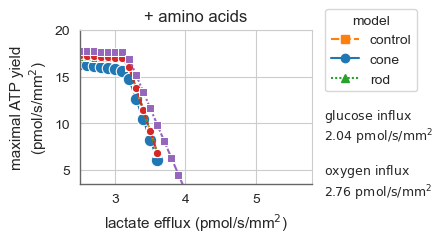

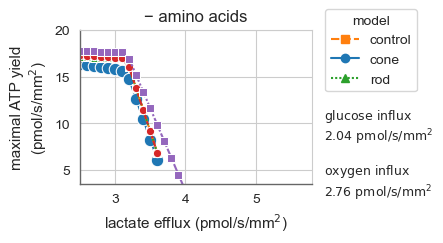

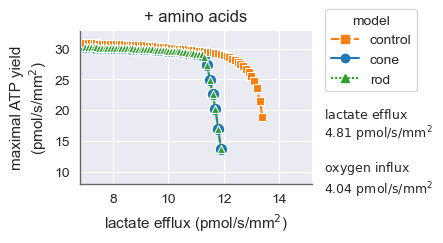

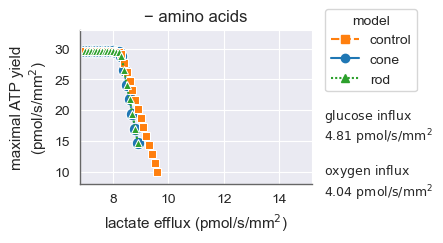

In [52]:
# CONFIGURATIONS SINGLE MODEL FIGS
def set_single_fig_configurations(glucose_lactate='lactate',foveal_perifoveal=''):

    dg_axes()
    if glucose_lactate == 'glucose':
        influx_efflux_text = " influx"
    elif glucose_lactate == 'lactate':
        influx_efflux_text = " efflux"
    else:
        return "Invalid parameter type"
    plt.xlabel(glucose_lactate + influx_efflux_text +' (pmol/s/mm$^2$)',fontsize=11)

    #change marker size
    ax.lines[0].set_markersize(9)
    ax.lines[1].set_markersize(6)
    ax.lines[2].set_markersize(6)
    ax.lines[3].set_markersize(6)
    ax.lines[4].set_markersize(6)

    plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
    plt.gcf().text(0.52, 1.02, foveal_perifoveal, ha='center', va='center', fontsize = 12)

    # change labels of legend
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[0], handles[2], handles[3], handles[4]]
    labels = ['control', 'cone', 'rod', 'cone + amino acids', 'rod + amino acids']

    ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.48, 1.1800))

    
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     TEST                                   #############
####################################################################################################
results_folder = create_folder('results', 'paper','sweep', 'lactate')

pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_lactate_single_perifoveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
df_light_aas__lactate_single_perifoveal = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single_perifoveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single_perifoveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

print('PERIFOVEAL')
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_no_aas_lactate_single_perifoveal,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 2.04), 2.76)
fig.savefig(results_folder + '//small_df_light_no_aas_lactate_single_perifoveal.png', bbox_inches='tight',dpi=600)

fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_light_no_aas_lactate_single_perifoveal,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 2.04), 2.76)
fig.savefig(results_folder + '//small+df_light_no_aas_lactate_single_perifoveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_aas,markers=['o','s','^'],ax=ax)
plt.title('+ amino acids')
ax.set_ylim(8,33)
ax.set_xlim(6.8,15.2)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('lactate', 4.81), 4.04)
fig.savefig(results_folder + '//small_dark_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(3,2))
sns.lineplot(data=df_dark_no_aas,markers=['o','s','^'],ax=ax)
plt.title('− amino acids')
ax.set_ylim(8,33)
ax.set_xlim(6.8,15.2)
set_combined_fig_configurations(glucose_lactate='lactate',foveal_perifoveal='')
add_textbox_bounds(('glucose', 4.81), 4.04)
fig.savefig(results_folder + '//small_dark_aas_lactate_sweep_perifoveal.png', bbox_inches='tight',dpi=600)


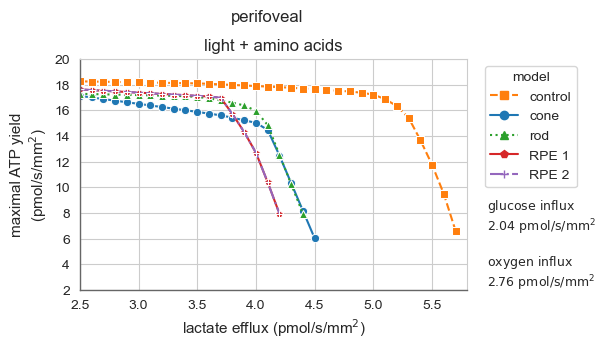

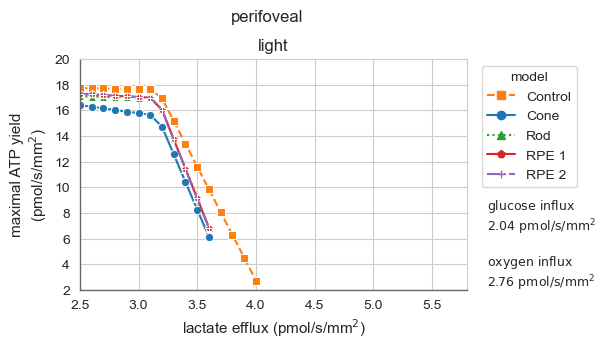

In [53]:
# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

##############################################################################
#####################         LACTATE LIGHT AAS       ########################
##############################################################################
import matplotlib.lines as mlines

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_lactate_sweep_single_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep_single_perifoveal.xlsx')  

####################################################################################
########################         LACTATE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_single_perifoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_lactate_sweep_single_perifoveal.xlsx')  

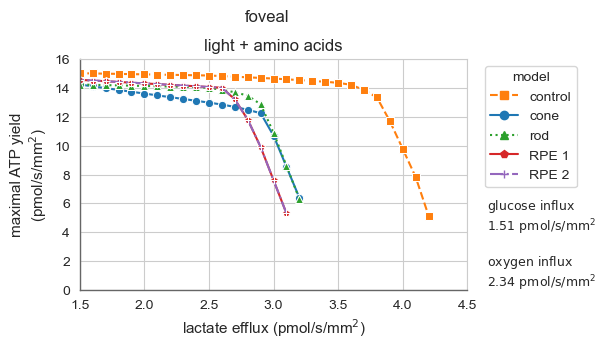

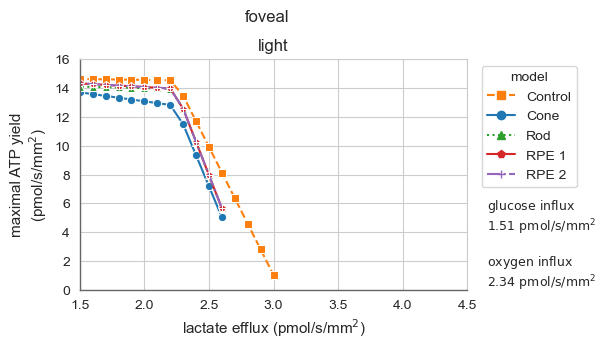

In [54]:
##############################################################################
#####################               FOVEAL            ########################
##############################################################################

# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single_foveal.pkl')
df_light_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single_foveal.pkl')
df_dark_no_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single_foveal.pkl')
df_dark_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

##############################################################################
#####################         LACTATE LIGHT AAS       ########################
##############################################################################
import matplotlib.lines as mlines

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(0,16)
ax.set_xlim(1.5,4.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$1.51\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.34\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_lactate_sweep_single_foveal.xlsx')  

####################################################################################
########################         LACTATE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(0,16)
ax.set_xlim(1.5,4.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_lactate_sweep_single_foveal.xlsx')  

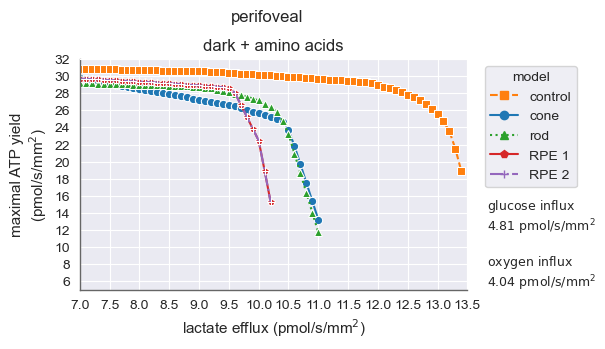

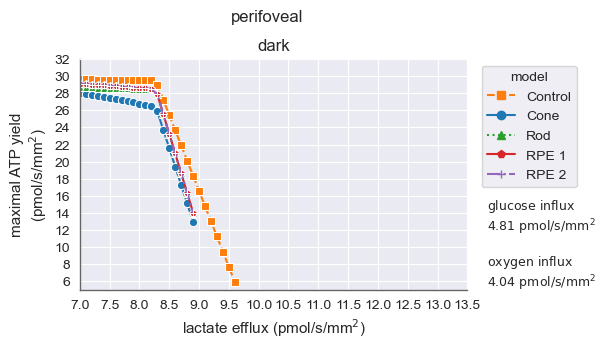

In [55]:
# load pickes
df_light_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

##############################################################################
#####################         LACTATE DARK AAS       ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(5,32)
ax.set_xlim(7,13.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$4.81\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_lactate_sweep_single_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_aas_lactate_sweep_single_perifoveal.xlsx')  

####################################################################################
########################         LACTATE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(5,32)
ax.set_xlim(7,13.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_single_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_no_aas_lactate_sweep_single_perifoveal.xlsx')  

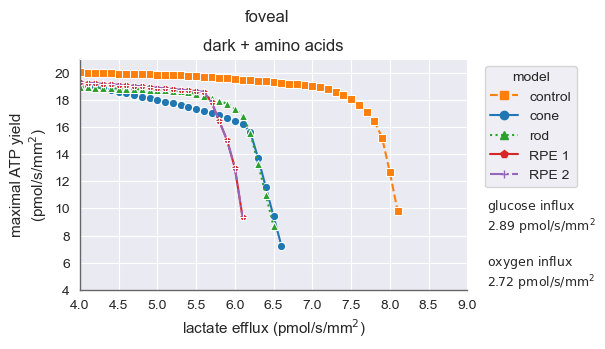

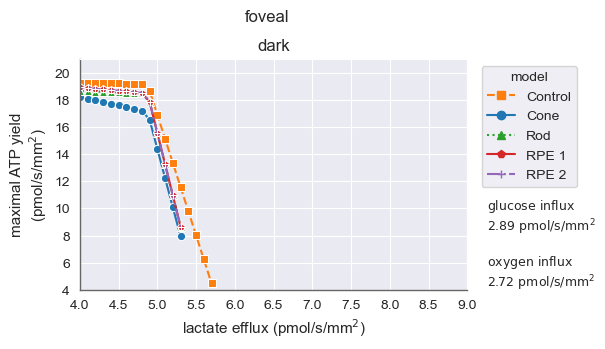

In [56]:

##############################################################################
#####################         FOVEAL  DARK        ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_aas_lactate_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(4,21)
ax.set_xlim(4,9)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))


# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.89\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.72\ \mathrm{pmol/s/mm}^2$'))


# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/dark_aas_lactate_sweep_single_foveal.xlsx')  

####################################################################################
########################         LACTATE DARK NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_no_aas_lactate_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(4,21)
ax.set_xlim(4,9)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/dark_no_aas_lactate_sweep_single_foveal.xlsx')  

In [57]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                GLUCOSE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(1,3,0.1)
# multiplication_factors_dark = my_range(2,5.5,0.1)


# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################
#         b = single_ex_bounds_light_perifoveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,''), '')
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''), '')
#         for i in multiplication_factors_light:
#             set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################
#         b = single_ex_bounds_dark_perifoveal
#         m = open_blood_exchange(m,blood_ratio0, get_gluc(b,''), '')
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]
#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''), '')
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose_single = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas_glucose_single = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas_glucose_single = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas_glucose_single = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder

# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas_glucose_single.to_pickle(pickle_folder + '/df_light_no_aas_glucose_single.pkl')
# df_light_aas_glucose_single.to_pickle(pickle_folder +  '/df_light_aas_glucose_single.pkl')
# df_dark_no_aas_glucose_single.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_single.pkl')
# df_dark_aas_glucose_single.to_pickle(pickle_folder +  '/df_dark_aas_glucose_single.pkl')

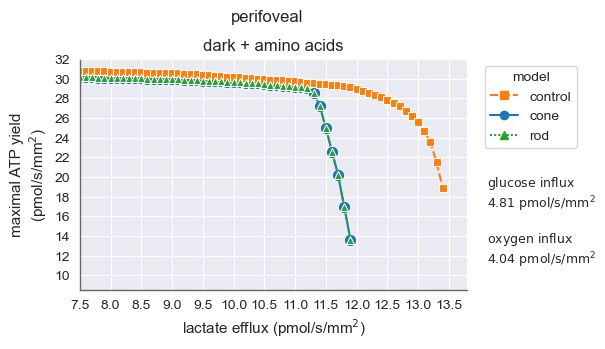

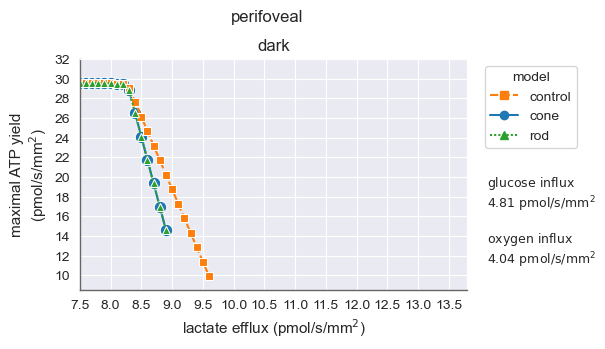

In [58]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                     DARK                                   #############
###########                                  perifoveal                                #############
####################################################################################################


# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')


# LACTATE SWEEP FIGURES LIGHT

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(8.5,32)
ax.set_xlim(7.5,13.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$4.81\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_aas_lactate_sweep_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_aas_lactate_sweep_perifoveal.xlsx')  


# LACTATE SWEEP
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

# x lim 0 to 30
ax.set_ylim(8.5,32)
ax.set_xlim(7.5,13.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_perifoveal.png', bbox_inches='tight')
df_dark_no_aas.to_excel(results_folder + '/dark_no_aas_lactate_sweep_perifoveal.xlsx')  

In [59]:
# # # # uncomment to run again (takes ~ 10 min)

# # # ####################################################################################################
# # # ###########                                GLUCOSE SWEEPS                              #############
# # # ###########                                 FOVEAL                                     #############
# # # ####################################################################################################

# multiplication_factors_light = my_range(0,8,0.1)
# multiplication_factors_dark = my_range(0,10,0.1)


# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################
#         b = single_ex_bounds_light_foveal
#         m = open_blood_exchange(m,blood_ratio0,get_gluc(b,''), '')
#         m = set_rxn_bounds(m,b)

#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio,get_gluc(b,''), '')
#         m = set_rxn_bounds(m,b)

#         for i in multiplication_factors_light:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})         
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################
#         b = single_ex_bounds_dark_foveal
#         m = open_blood_exchange(m,blood_ratio0,get_gluc(b,''), '')
#         m = set_rxn_bounds(m,b)

#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#         m = open_blood_exchange(m,blood_ratio, get_gluc(b,''), '')  
#         m = set_rxn_bounds(m,b)
#         for i in multiplication_factors_dark:
#             m = set_rxn_bounds(m,{glucose_ID:(-i,-i)})
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose_single_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_glucose_single_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_glucose_single_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_glucose_single_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder

# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas_glucose_single_foveal.to_pickle(pickle_folder + '/df_light_no_aas_glucose_single_foveal.pkl')
# df_light_aas_glucose_single_foveal.to_pickle(pickle_folder +  '/df_light_aas_glucose_single_foveal.pkl')
# df_dark_no_aas_glucose_single_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_single_foveal.pkl')
# df_dark_aas_glucose_single_foveal.to_pickle(pickle_folder +  '/df_dark_aas_glucose_single_foveal.pkl')

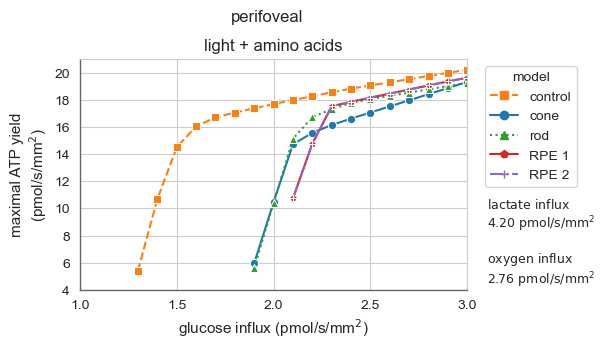

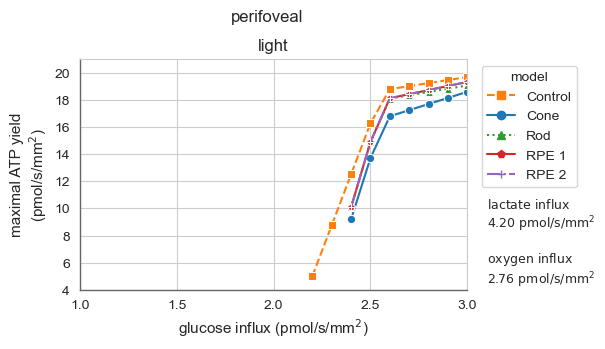

In [60]:
# load glucose pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_single = pd.read_pickle(pickle_folder + '/df_light_no_aas_glucose_single.pkl')
df_light_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_single.pkl')
df_dark_no_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_single.pkl')
df_dark_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'glucose')


##############################################################################
#####################         GLUCOSE LIGHT AAS       ########################
##############################################################################

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(4,21)
ax.set_xlim(1,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx}$',
    r'$4.20\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_glucose_sweep_single_perifoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_glucose_sweep_single_perifoveal.xlsx')  

####################################################################################
########################         GLUCOSE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_no_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(4,21)
ax.set_xlim(1,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_single_perifoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_glucose_sweep_single_perifoveal.xlsx')  

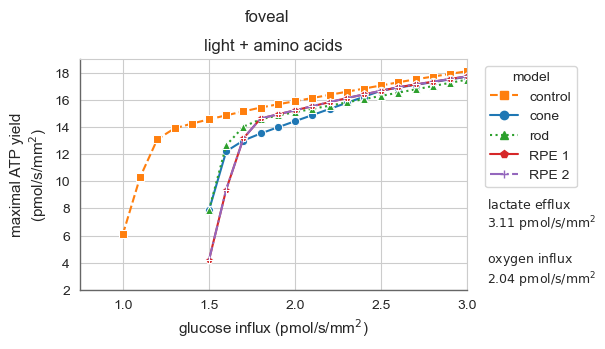

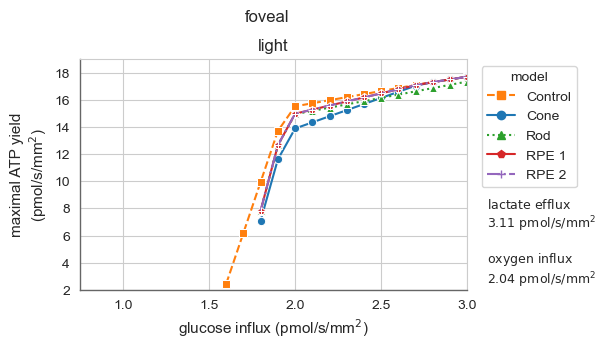

In [61]:
##############################################################################
#####################               FOVEAL            ########################
##############################################################################


# load glucose pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_single_foveal = pd.read_pickle(pickle_folder + '/df_light_no_aas_glucose_single_foveal.pkl')
df_light_aas_glucose_single_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_single_foveal.pkl')
df_dark_no_aas_glucose_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_single_foveal.pkl')
df_dark_aas_glucose_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_single_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'glucose')


##############################################################################
#####################         GLUCOSE LIGHT AAS       ########################
##############################################################################

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(2,19)
ax.set_xlim(.75,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$3.11\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_glucose_sweep_single_foveal.xlsx')  

####################################################################################
########################         GLUCOSE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_no_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(2,19)
ax.set_xlim(.75,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_glucose_sweep_single_foveal.xlsx')  

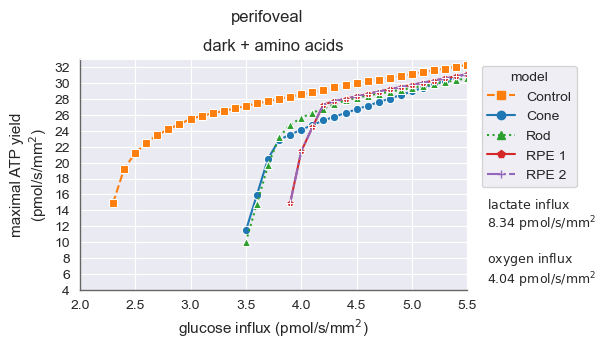

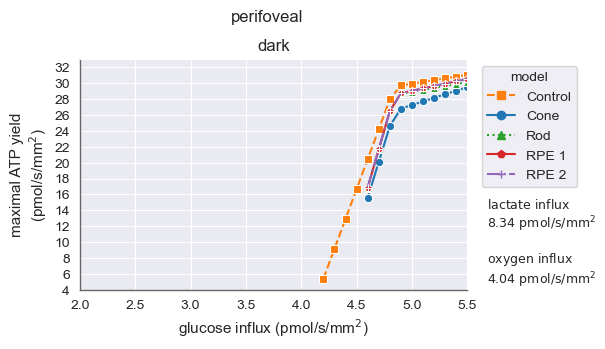

In [62]:
# load glucose pickles
df_dark_no_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_single.pkl')
df_dark_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'glucose')

##############################################################################
#####################         GLUCOSE DARK AAS       ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(4,33)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx}$',
    r'$8.34\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_glucose_sweep_single_perifoveal.png', bbox_inches='tight')
df_dark_aas.to_excel(results_folder + '/dark_aas_glucose_sweep_single_perifoveal.xlsx')  

####################################################################################
########################         GLUCOSE DARK NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_no_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'perifoveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(4,33)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_single_perifoveal.png', bbox_inches='tight')
df_dark_no_aas.to_excel(results_folder + '/dark_no_aas_glucose_sweep_single_perifoveal.xlsx')  

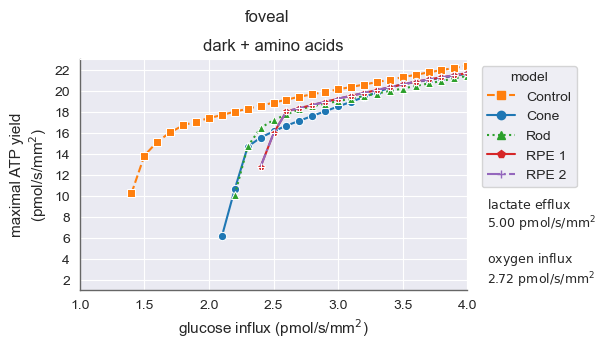

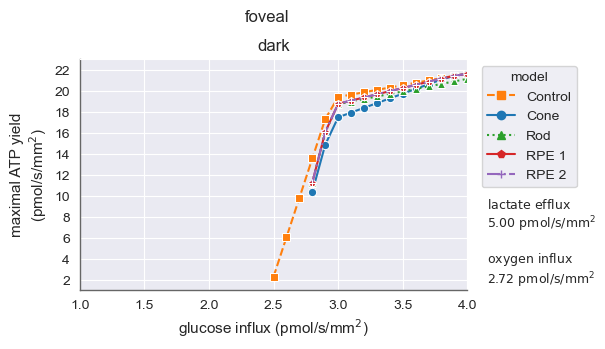

In [63]:
##############################################################################
#####################               FOVEAL            ########################
##############################################################################

results_folder = create_folder('results', 'paper','sweep', 'glucose')

##############################################################################
#####################         GLUCOSE DARK AAS       ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(1,23)
ax.set_xlim(1,4)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$5.00\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.72\ \mathrm{pmol/s/mm}^2$')) 


# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_dark_aas_foveal.to_excel(results_folder + '/dark_aas_glucose_sweep_single_foveal.xlsx')  

####################################################################################
########################         GLUCOSE DARK NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_no_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('maximal ATP yield\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')
plt.gcf().text(0.5, 1.02, 'foveal', ha='center', va='center', fontsize = 12)

dg_axes()

ax.set_ylim(1,23)
ax.set_xlim(1,4)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_dark_no_aas_foveal.to_excel(results_folder + '/dark_no_aas_glucose_sweep_single_foveal.xlsx')  

In [64]:
# oxygen sweep



In [65]:
# find min glucose boundaries for sweeps 

def make_df_min(s,c,name_string):
    s = pd.DataFrame(s.idxmin())
    c = pd.DataFrame(c.idxmin())
    sc = pd.concat([s,c], axis=0)
    sc.columns = [name_string]
    return sc

# GLUCOSE MINS (LIGHT/DARK, AAS/NO AAS)
sc1 = make_df_min(df_light_no_aas_glucose_single,df_light_no_aas_glucose,'light_no_aas__glucose_min')
sc2 = make_df_min(df_light_aas_glucose_single,df_light_aas_glucose,'light_aas__glucose_min')
sc3 = make_df_min(df_dark_no_aas_glucose_single,df_dark_no_aas_glucose,'dark_no_aas__glucose_min')
sc4 = make_df_min(df_dark_aas_glucose_single,df_dark_aas_glucose,'dark_aas__glucose_min')
# LACTATE MINS (LIGHT/DARK, AAS/NO AAS)
sc5 = make_df_min(df_light_no_aas_lactate_single,df_light_no_aas,'light_no_aas__lactate_min')
sc6 = make_df_min(df_light_aas_lactate_single,df_light_aas,'light_aas__lactate_min')
sc7 = make_df_min(df_dark_no_aas_lactate_single,df_dark_no_aas,'dark_no_aas__lactate_min')
sc8 = make_df_min(df_dark_aas_lactate_single,df_dark_aas,'dark_aas__lactate_min')

# do same for foveal
sc9 = make_df_min(df_light_no_aas_glucose_single_foveal,df_light_no_aas_glucose_foveal,'light_no_aas_foveal__glucose_min')
sc10 = make_df_min(df_light_aas_glucose_single_foveal,df_light_aas_glucose_foveal,'light_aas_foveal__glucose_min')
sc11 = make_df_min(df_dark_no_aas_glucose_single_foveal,df_dark_no_aas_glucose_foveal,'dark_no_aas_foveal__glucose_min')
sc12 = make_df_min(df_dark_aas_glucose_single_foveal,df_dark_aas_glucose_foveal,'dark_aas_foveal__glucose_min')
# LACTATE MINS (LIGHT/DARK, AAS/NO AAS)
sc13 = make_df_min(df_light_no_aas_lactate_single_foveal,df_light_no_aas_foveal,'light_no_aas_foveal__lactate_min')
sc14 = make_df_min(df_light_aas_lactate_single_foveal,df_light_aas_foveal,'light_aas_foveal__lactate_min')
sc15 = make_df_min(df_dark_no_aas_lactate_single_foveal,df_dark_no_aas_foveal,'dark_no_aas_foveal__lactate_min')
sc16 = make_df_min(df_dark_aas_lactate_single_foveal,df_dark_aas_foveal,'dark_aas_foveal__lactate_min')

# concatenate all min dfs
sc = pd.concat([sc1, sc9, sc2, sc10, sc3, sc11, sc4, sc12, sc5, sc13, sc6, sc14, sc7, sc15, sc8, sc16], axis=1)

# write sc as excel into results folder
results_folder = create_folder('results', 'paper','sweep')
# sc.to_excel(results_folder + '/min_lactate_glucose.xlsx') # uncomment to write excel file

sc

,light_no_aas__glucose_min,light_no_aas_foveal__glucose_min,light_aas__glucose_min,light_aas_foveal__glucose_min,dark_no_aas__glucose_min,dark_no_aas_foveal__glucose_min,dark_aas__glucose_min,dark_aas_foveal__glucose_min,light_no_aas__lactate_min,light_no_aas_foveal__lactate_min,light_aas__lactate_min,light_aas_foveal__lactate_min,dark_no_aas__lactate_min,dark_no_aas_foveal__lactate_min,dark_aas__lactate_min,dark_aas_foveal__lactate_min
mod_RPE_PRcone_Lukowski_singlePR,2.4,1.8,1.9,1.5,4.6,2.8,3.5,2.1,3.6,2.6,4.5,3.2,8.9,5.3,11.0,6.6
mod_RPE_PRcone_Lukowski_singleRPE,2.4,1.8,2.1,1.5,4.6,2.8,3.9,2.4,3.6,2.6,4.2,3.1,8.9,5.3,10.2,6.1
mod_RPE_PRrod_Lukowski_singlePR,2.4,1.8,1.9,1.5,4.6,2.8,3.5,2.2,3.6,2.6,4.4,3.2,8.9,5.3,11.0,6.5
mod_RPE_PRrod_Lukowski_singleRPE,2.4,1.8,2.1,1.5,4.6,2.8,3.9,2.4,3.6,2.6,4.2,3.1,8.9,5.3,10.2,6.1
Human-GEM_28062023,2.2,1.6,1.3,1.0,4.2,2.5,2.3,1.4,4.0,3.0,5.7,4.2,9.6,5.7,13.4,8.1
mod_RPE_PRcone_Lukowski,2.4,1.6,1.7,1.2,4.6,2.6,3.1,1.9,3.6,2.9,4.9,3.7,8.9,5.7,11.9,7.1
mod_RPE_PRcontrol,2.1,1.6,1.3,1.0,4.2,2.5,2.3,1.4,4.0,3.0,5.7,4.2,9.6,5.7,13.4,8.1
mod_RPE_PRrod_Lukowski,2.4,1.6,1.7,1.2,4.6,2.6,3.1,1.9,3.6,2.9,4.9,3.7,8.9,5.7,11.9,7.1


In [66]:
# turn sc into long format for plotting (melt) keep index as column
sc_long = sc.reset_index()
sc_long = sc.melt(var_name='model', value_name='exchange_threshold')
sc_long

,model,exchange_threshold
0,light_no_aas__glucose_min,2.4
1,light_no_aas__glucose_min,2.4
2,light_no_aas__glucose_min,2.4
3,light_no_aas__glucose_min,2.4
4,light_no_aas__glucose_min,2.2
...,...,...
123,dark_aas_foveal__lactate_min,6.1
124,dark_aas_foveal__lactate_min,8.1
125,dark_aas_foveal__lactate_min,7.1
126,dark_aas_foveal__lactate_min,8.1


In [67]:
# get colorblind palette colours
colorblind_palette = sns.color_palette('colorblind')
blue_green = [colorblind_palette[0], colorblind_palette[2]]

In [68]:
sc_reindexed = sc.reset_index()
sc_reindexed
# melt to long keeping index as variable
sc_long = sc_reindexed.melt(id_vars='index', var_name='condition', value_name='exchange_threshold')

sc_long
# single / combined
sc_long['single/combined'] = sc_long['index'].str.extract('(single)', expand=True)
sc_long['single/combined'] = sc_long['single/combined'].fillna('combined')

# RPE / PRcone / PRrod / control (HUMAN) / RPE-PRcone / RPE-PRrod / RPE-PR control 

# PRcone in celltype col if index contains PRcone AND single
# select cases where index has singlePR and cone in name

# PR
sc_long.loc[(sc_long['index'].str.contains('singlePR')) & (sc_long['index'].str.contains('cone')), 'celltype'] = 'PRcone'
sc_long.loc[(sc_long['index'].str.contains('singlePR')) & (sc_long['index'].str.contains('rod')), 'celltype'] = 'PRrod'
# RPE
sc_long.loc[(sc_long['index'].str.contains('singleRPE')) & (sc_long['index'].str.contains('cone')), 'celltype'] = 'RPE1'
sc_long.loc[(sc_long['index'].str.contains('singleRPE')) & (sc_long['index'].str.contains('rod')), 'celltype'] = 'RPE2'
# control (Human1)
sc_long.loc[(sc_long['index'].str.contains('Human')) , 'celltype'] = 'control'
# COMBINED MODELS
sc_long.loc[(sc_long['index'].str.contains('RPE_PRcone')) & (~sc_long['index'].str.contains('single')), 'celltype'] = 'RPE-PRcone' 
sc_long.loc[(sc_long['index'].str.contains('RPE_PRrod')) & (~sc_long['index'].str.contains('single')), 'celltype'] = 'RPE-PRrod'
sc_long.loc[(sc_long['index'].str.contains('control')) , 'celltype'] = 'RPE-PR control'

sc_long['light/dark'] = sc_long['condition'].str.extract('(light|dark)', expand=True) # light / dark
sc_long['aas/no aas'] = sc_long['condition'].str.extract('(aas|no_aas)', expand=True) # aas / no aas
sc_long['glucose/lactate'] = sc_long['condition'].str.extract('(glucose|lactate)', expand=True) # glucose / lactate

# foveal / perifoveal
sc_long['foveal/perifoveal'] = sc_long['condition'].str.extract('(foveal)', expand=True)
sc_long['foveal/perifoveal'] = sc_long['foveal/perifoveal'].fillna('perifoveal')

# reorder celtype to ['control', 'RPE1', 'RPE2', 'PRcone', 'PRrod', 'RPE-PRcone', 'RPE-PRrod', 'RPE-PR control']
sc_long['celltype'] = pd.Categorical(sc_long['celltype'], ['control', 'RPE1', 'RPE2', 'PRcone', 'PRrod', \
                                                            'RPE-PR control','RPE-PRcone', 'RPE-PRrod'])
# add a column in which aas/no_ass and foveal/perifoveal are combined
sc_long['aas/no aas - foveal/perifoveal'] = sc_long['aas/no aas'] + " - " + sc_long['foveal/perifoveal']

sc_long

,index,condition,exchange_threshold,single/combined,celltype,light/dark,aas/no aas,glucose/lactate,foveal/perifoveal,aas/no aas - foveal/perifoveal
0,mod_RPE_PRcone_Lukowski_singlePR,light_no_aas__glucose_min,2.4,single,PRcone,light,no_aas,glucose,perifoveal,no_aas - perifoveal
1,mod_RPE_PRcone_Lukowski_singleRPE,light_no_aas__glucose_min,2.4,single,RPE1,light,no_aas,glucose,perifoveal,no_aas - perifoveal
2,mod_RPE_PRrod_Lukowski_singlePR,light_no_aas__glucose_min,2.4,single,PRrod,light,no_aas,glucose,perifoveal,no_aas - perifoveal
3,mod_RPE_PRrod_Lukowski_singleRPE,light_no_aas__glucose_min,2.4,single,RPE2,light,no_aas,glucose,perifoveal,no_aas - perifoveal
4,Human-GEM_28062023,light_no_aas__glucose_min,2.2,combined,control,light,no_aas,glucose,perifoveal,no_aas - perifoveal
...,...,...,...,...,...,...,...,...,...,...
123,mod_RPE_PRrod_Lukowski_singleRPE,dark_aas_foveal__lactate_min,6.1,single,RPE2,dark,aas,lactate,foveal,aas - foveal
124,Human-GEM_28062023,dark_aas_foveal__lactate_min,8.1,combined,control,dark,aas,lactate,foveal,aas - foveal
125,mod_RPE_PRcone_Lukowski,dark_aas_foveal__lactate_min,7.1,combined,RPE-PRcone,dark,aas,lactate,foveal,aas - foveal
126,mod_RPE_PRcontrol,dark_aas_foveal__lactate_min,8.1,combined,RPE-PR control,dark,aas,lactate,foveal,aas - foveal


In [69]:
# fetch green and blue used in plot
blue = (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)
green = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00784313725490196, 0.6196078431372549, 0.45098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('x').  Matplotlib

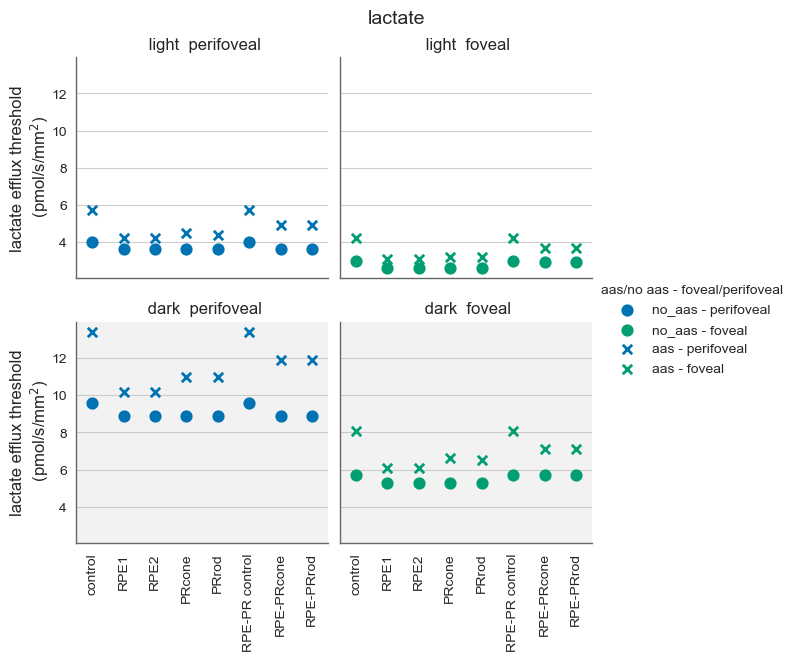

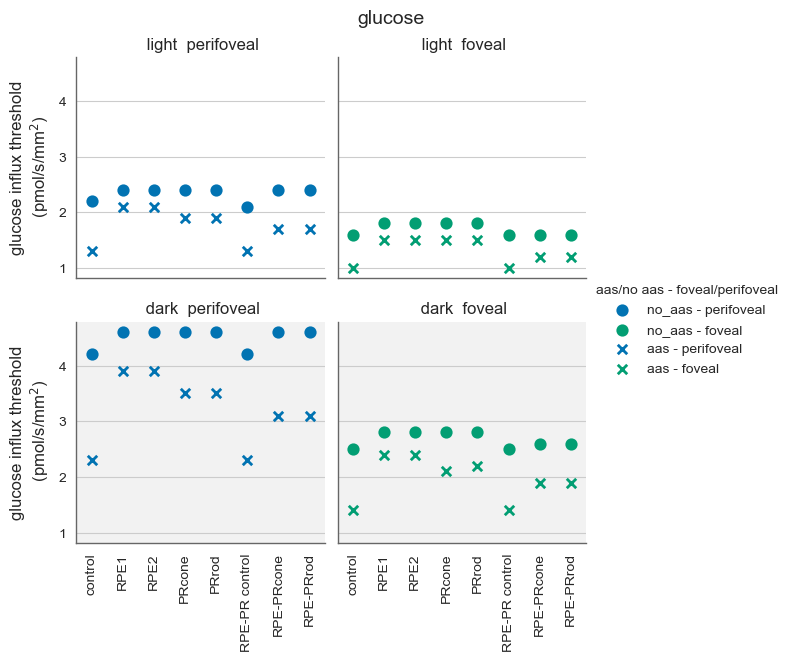

In [70]:
# represent sc table as catplot bar graphs
sc_long_lactate = sc_long[sc_long['glucose/lactate'] == 'lactate']
sc_long_glucose = sc_long[sc_long['glucose/lactate'] == 'glucose']

# whitegrid
sns.set_style("whitegrid", {'axes.grid' : True})

sns.catplot(data=sc_long_lactate, kind='point', \
             height=3, aspect=1, palette=blue_green, markers=['o','o','x','x'], \
                x='celltype', y='exchange_threshold', hue='aas/no aas - foveal/perifoveal',\
                      col='foveal/perifoveal', row='light/dark', legend=True)


# remove lines between points (for both aas and no aas)
for ax in plt.gcf().axes:
    plt.setp(ax.lines, linewidth=0)

dg_axes()

for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.ylabel('lactate efflux threshold\n (pmol/s/mm$^2$)', fontsize=12)
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)
    plt.xlabel('')    

# change subtitles of subplots
for subplot in range(len(plt.gcf().axes)):
    # get word after first = sign and | sign and word after second = sign
      title = plt.gcf().axes[subplot].get_title()
      word1 = title.split('=')[1].split('|')[0]
      word2 = title.split('=')[2]
      # set new title
      plt.gcf().axes[subplot].set_title(word1 + word2)

# make second row backgorund lightgray 
for subplot in range(2,4):
    plt.gcf().axes[subplot].set_facecolor((0.95,0.95,0.95))

# change titles
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle('lactate', fontsize=14)

plt.subplots_adjust(hspace=0.2) 
plt.subplots_adjust(wspace=0.05)

############################################################################################
#################################      GLUCOSE      ########################################
############################################################################################

sns.catplot(data=sc_long_glucose, kind='point', \
             height=3, aspect=1, palette=blue_green, markers=['o','o','x','x'], \
                x='celltype', y='exchange_threshold', hue='aas/no aas - foveal/perifoveal',\
                      col='foveal/perifoveal', row='light/dark', legend=True)

# remove lines between points (for both aas and no aas)
for ax in plt.gcf().axes:
    plt.setp(ax.lines, linewidth=0)

dg_axes()

for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.ylabel('glucose influx threshold\n (pmol/s/mm$^2$)', fontsize=12)
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)
    plt.xlabel('')    

# change subtitles of subplots
for subplot in range(len(plt.gcf().axes)):
    # get word after first = sign and | sign and word after second = sign
      title = plt.gcf().axes[subplot].get_title()
      word1 = title.split('=')[1].split('|')[0]
      word2 = title.split('=')[2]
      # set new title
      plt.gcf().axes[subplot].set_title(word1 + word2)

# make second row backgorund lightgray 
for subplot in range(2,4):
    plt.gcf().axes[subplot].set_facecolor((0.95,0.95,0.95))

# change titles
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle('glucose', fontsize=14)

plt.subplots_adjust(hspace=0.2) 
plt.subplots_adjust(wspace=0.05)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00784313725490196, 0.6196078431372549, 0.45098039215686275)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.00392156862745098, 0.45098039215686275, 0.6980392156862745)) for an unfilled marker ('x').  Matplotlib

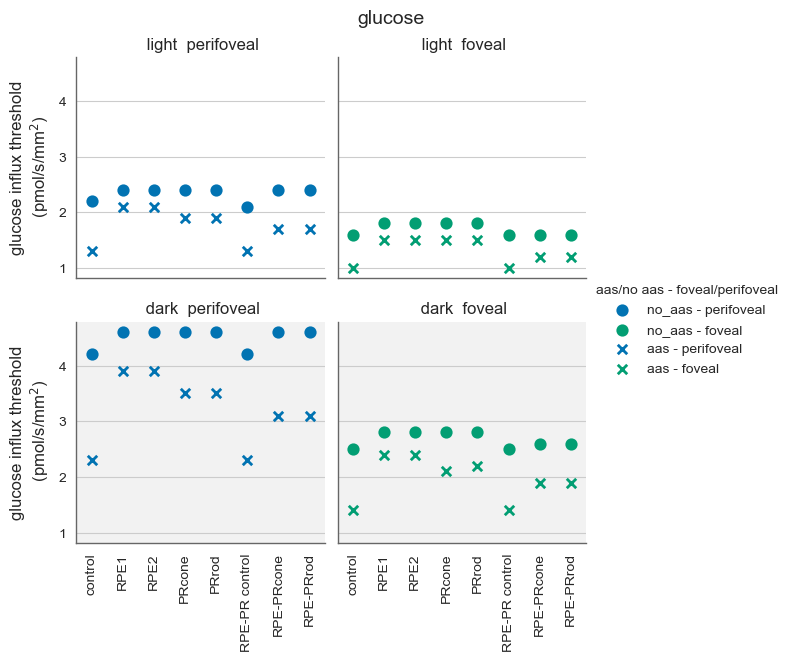

In [71]:
# represent sc table as catplot bar graphs
sc_long_glucose = sc_long[sc_long['glucose/lactate'] == 'glucose']

# whitegrid
sns.set_style("whitegrid", {'axes.grid' : True})

sns.catplot(data=sc_long_glucose, kind='point', \
             height=3, aspect=1, palette=blue_green, markers=['o','o','x','x'],  \
                x='celltype', y='exchange_threshold', hue='aas/no aas - foveal/perifoveal',\
                      col='foveal/perifoveal', row='light/dark', legend=True)

# remove lines between points (for both aas and no aas)
for ax in plt.gcf().axes:
    plt.setp(ax.lines, linewidth=0)

dg_axes()

# change subtitles of subplots
for subplot in range(len(plt.gcf().axes)):
      title = plt.gcf().axes[subplot].get_title()
      word1 = title.split('=')[1].split('|')[0]
      word2 = title.split('=')[2]
      plt.gcf().axes[subplot].set_title(word1 + word2)

# make second row backgorund lightgray 
for subplot in range(2,4):
    plt.gcf().axes[subplot].set_facecolor((0.95,0.95,0.95))

# change titles
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle('glucose', fontsize=14)

for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.ylabel('glucose influx threshold\n (pmol/s/mm$^2$)', fontsize=12)
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)
    plt.xlabel('')
    plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.05)

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\4139422815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sc_long_combined['celltype'] = pd.Categorical(sc_long_combined['celltype'], ['RPE-PR control','RPE-PRcone', 'RPE-PRrod'])
C:\Users\prins\AppData\Local\Temp\ipykernel_8836\4139422815.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sc_long_lactate = sc_long_combined[sc_long['glucose/lactate'] == 'lactate']
C:\Users\prins\AppData\Local\Temp\ipykernel_8836\4139422815.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sc_long_glucose = sc_long_combined[sc_long['glucose/lactate'] == 'glucose']
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\seaborn\categorica

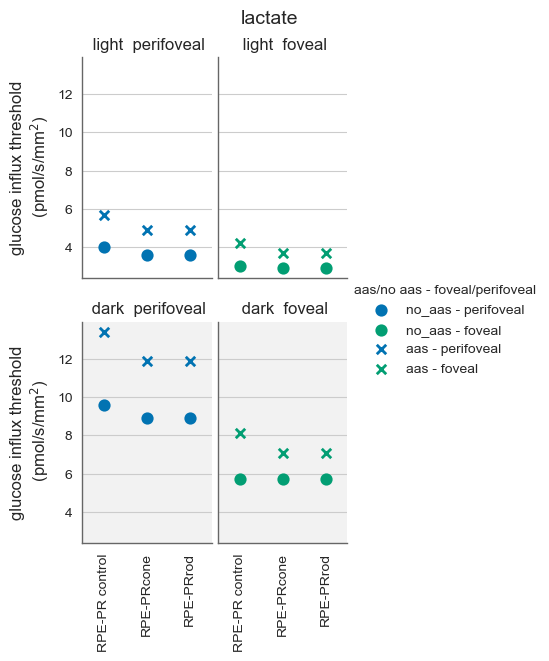

In [72]:
# make figures for combined models only
sc_long_combined = sc_long[(sc_long['celltype'] == 'RPE-PRcone') | (sc_long['celltype'] == 'RPE-PRrod') | (sc_long['celltype'] == 'RPE-PR control')]
sc_long_combined['celltype'] = pd.Categorical(sc_long_combined['celltype'], ['RPE-PR control','RPE-PRcone', 'RPE-PRrod'])

# represent sc table as catplot bar graphs
sc_long_lactate = sc_long_combined[sc_long['glucose/lactate'] == 'lactate']
sc_long_glucose = sc_long_combined[sc_long['glucose/lactate'] == 'glucose']
sc_long_lactate_perifoveal = sc_long_lactate[sc_long_lactate['foveal/perifoveal'] == 'perifoveal']
sc_long_lactate_foveal = sc_long_lactate[sc_long_lactate['foveal/perifoveal'] == 'foveal']

# whitegrid
sns.set_style("whitegrid", {'axes.grid' : True})
custom_palette = [blue, green, blue, green]  # Define your custom colors

sns.catplot(data=sc_long_lactate, kind='point', \
             height=3, aspect=.6, \
                x='celltype', y='exchange_threshold', hue='aas/no aas - foveal/perifoveal',\
                row='light/dark',col='foveal/perifoveal' , legend=True,\
                markers=['o','o','x','x'],
                palette = blue_green)

for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.ylabel('glucose influx threshold\n (pmol/s/mm$^2$)', fontsize=12)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.setp(ax.lines, linewidth=0)

dg_axes()
   
# change subtitles of subplots
for subplot in range(len(plt.gcf().axes)):
      title = plt.gcf().axes[subplot].get_title()
      word1 = title.split('=')[1].split('|')[0]
      word2 = title.split('=')[2]
      plt.gcf().axes[subplot].set_title(word1 + word2)

# make second row backgorund lightgray 
for subplot in range(2,4):
    plt.gcf().axes[subplot].set_facecolor((0.95,0.95,0.95))

# change titles
plt.subplots_adjust(top=0.9)
plt.gcf().suptitle('lactate', fontsize=14, ha='center')

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.05)


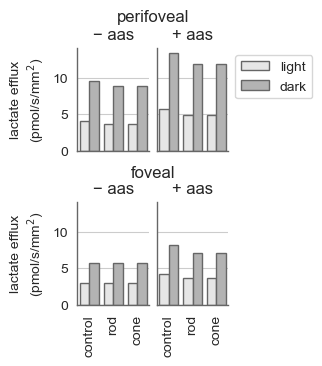

In [73]:
# set whitegrid style
sns.set_style("whitegrid")

my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

g = sns.catplot(data=sc_long_lactate, kind='bar', \
             height=3, aspect=.6, \
                x='celltype', y='exchange_threshold', hue='light/dark',\
                row='foveal/perifoveal',col='aas/no aas' , legend=False,\
                palette = my_palette)

plt.gcf().set_size_inches(2,3)

dg_axes()

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('lactate efflux\n(pmol/s/mm$^2$)')
    ax.set_xlabel('') 
    ax.set_xticklabels(['control','rod','cone'], rotation=90)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# change titles of subplots
titles = ['− aas', '+ aas','− aas', '+ aas']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)
    
plt.gcf().text(0.54, 1.05, 'perifoveal', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.54, 0.53, 'foveal', ha='center', va='center', fontsize = 12)

# move legend to the right
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[2].legend().remove()
plt.gcf().axes[3].legend().remove()
plt.gcf().axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.subplots_adjust(wspace = 0.1)
plt.subplots_adjust(hspace = 0.5)

# save figure in results folder in user folder
plt.savefig(results_folder + '/test.png', dpi=600, bbox_inches='tight')

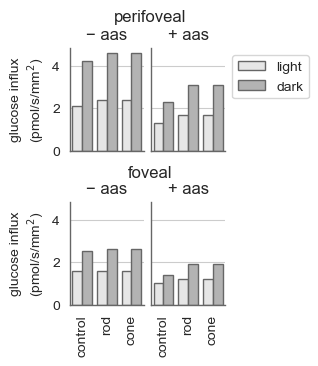

In [74]:
# set whitegrid style
sns.set_style("whitegrid")
g = sns.catplot(data=sc_long_glucose, kind='bar', \
             height=3, aspect=.6, \
                x='celltype', y='exchange_threshold', hue='light/dark',\
                row='foveal/perifoveal',col='aas/no aas' , legend=False,\
                palette = my_palette)

plt.gcf().set_size_inches(2,3)

dg_axes()

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('glucose influx\n(pmol/s/mm$^2$)')
    ax.set_xlabel('') 
    ax.set_xticklabels(['control','rod','cone'], rotation=90)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# change titles of subplots
titles = ['− aas', '+ aas','− aas', '+ aas']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)
    
plt.gcf().text(0.54, 1.05, 'perifoveal', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.54, 0.53, 'foveal', ha='center', va='center', fontsize = 12)

# move legend to the right
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[2].legend().remove()
plt.gcf().axes[3].legend().remove()
plt.gcf().axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.subplots_adjust(wspace = 0.1)
plt.subplots_adjust(hspace = 0.5)

# save figure in results folder in user folder
plt.savefig(results_folder + '/test2.png', dpi=600, bbox_inches='tight')

Create subsystem models (for displaying networks in Escher)

In [75]:
# write function to create models that only contain specific subsystem reactions
def create_subsystem_model(m, subsystem):
    m_subsystem = cobra.Model()
    m_subsystem.add_reactions([r for r in m.reactions if r.subsystem == subsystem])
    # create subsystem_str with underscores instead of spaces and no slashes
    subsystem_str = subsystem.replace(' ', '_').replace('/', '')


    m_subsystem.name = m.name + '_' + subsystem_str
    m_subsystem.id = m.id +'_' + subsystem_str
    return m_subsystem

# make new model with only selected reactions 'glycolysis_rxns' 
m_glycolysis = create_subsystem_model(model_list[1], 'Glycolysis / Gluconeogenesis')
m_glycolysis

Name,mod_RPE_PRcone_Lukowski_Glycolysis__Gluconeogenesis
Memory address,12d33af5840
Number of metabolites,98
Number of reactions,46
Number of genes,60
Number of groups,0
Objective expression,0
Compartments,"c_RPE, x_RPE, m_RPE, c_PR, x_PR, m_PR"


In [76]:
# create results_folder
from cobra.io import  write_sbml_model, save_json_model

results_folder = create_folder('results', 'subset_models','Glycolysis_Gluconeogenesis')
for m in model_list:
    m_subsystem = create_subsystem_model(m, 'Glycolysis / Gluconeogenesis')
    r_objective = [r.id for r in m_subsystem.reactions if 'MAR04358' in r.id]
    for r in r_objective:
        if '_PR' in r:
            m_subsystem.objective = r
        else:
            m_subsystem.objective = r_objective[0]
    m_subsystem.optimize()  
    print(m_subsystem.objective.value)
    # save m_subsystem in results_folder with name m_subsystem.id + glycolysis as sbmbl model
    write_sbml_model(m_subsystem, results_folder + '/' + str(m_subsystem.id) + '_glycolysis.xml')
    save_json_model(m_subsystem, results_folder + '/' + str(m_subsystem.id) + '_glycolysis.json')
    print(str(m_subsystem.id))

0.0
Human-GEM_28062023_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcone_Lukowski_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcone_Lukowski_singlePR_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcone_Lukowski_singleRPE_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcontrol_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRrod_Lukowski_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRrod_Lukowski_singlePR_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRrod_Lukowski_singleRPE_Glycolysis__Gluconeogenesis


In [77]:
m_subsystem = create_subsystem_model(model_list[0], 'Glycolysis / Gluconeogenesis')
from src.get_info import add_compartment2rxn
# list reactions in m_subsystem
rxns_subsystem = pd.DataFrame([[r.id,r.name,add_compartment2rxn(r)] for r in m_subsystem.reactions])
rxns_subsystem.head().append(rxns_subsystem.tail())

C:\Users\prins\AppData\Local\Temp\ipykernel_8836\2861632533.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rxns_subsystem.head().append(rxns_subsystem.tail())


,0,1,2
0,MAR03905,ethanol:NAD+ oxidoreductase,ethanol[c] + NAD+[c] --> acetaldehyde[c] + H+[...
1,MAR03907,Ethanol:NADP+ oxidoreductase,ethanol[c] + NADP+[c] --> acetaldehyde[c] + H+...
2,MAR04097,Acetate:CoA ligase (AMP-forming),acetate[c] + ATP[c] + CoA[c] --> acetyl-CoA[c]...
3,MAR04099,Acetate:CoA ligase (AMP-forming),acetate[m] + ATP[m] + CoA[m] --> acetyl-CoA[m]...
4,MAR04108,acetyl adenylate:CoA acetyltransferase,acetyl adenylate[c] + CoA[c] --> acetyl-CoA[c]...
39,MAR20040,MAR20040,H2O[c] + NADP+[c] + hexanal[c] --> 2.0 H+[c] +...
40,MAR20041,MAR20041,4-hydroxy-2-nonenal[c] + H2O[c] + NADP+[c] -->...
41,MAR20042,MAR20042,H2O[c] + NADP+[c] + (2E)-octenal[c] --> 2.0 H+...
42,MAR20043,MAR20043,H2O[c] + NAD+[c] + (2E)-octenal[c] --> 2.0 H+[...
43,MAR20069,MAR20069,2-(alpha-hydroxyethyl)thiamine-diphosphate[m] ...


ATP YIELD PER METABOLITE, DIFFERENT OXYGEN LEVELS

In [78]:
#####################################################################################################################################
########################################  ATP YIELD PER METABOLITE, DIFFERENT OXYGEN LEVELS  ########################################
#####################################################################################################################################

# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

##############################################################
#######    total exchange (for single models)        #########
##############################################################

ox_bounds_dark_single = {'MAR09048':(-4.04,-4.04)}
ox_bounds_light_single = {'MAR09048':(-2.76,-2.76)}

##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

ox_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                      'MAR09048_PR':(-0.56,-0.56)}          

ox_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR09048_PR':(-0.27,-0.27)}

In [79]:
def get_by_id_RPE_PR(m, id):
    reactions_list = [r.id for r in m.reactions]
    if (id + '_RPE') in reactions_list:
        return m.reactions.get_by_id(id + '_RPE')
    elif (id + '_PR') in reactions_list:
        return m.reactions.get_by_id(id + '_PR')
    elif (id) in reactions_list:
        return m.reactions.get_by_id(id)
    else:
        print('exchange reaction not found')
        
get_by_id_RPE_PR(model_list[0], 'MAR09048')

Reaction identifier,MAR09048
Name,
Memory address,0x12c2933bf10
Stoichiometry,MAM02630e --> O2 -->
GPR,
Lower bound,0
Upper bound,1000


In [80]:
oxygen_levels  = [(-1000,0),(-4.04,0),(-2.76,0),(0,0)]
results_dict_single = {}

br_keys = br.keys()
for model in single_models + Human1_models:
    with model as m:
        reactions_list = [r.id for r in m.reactions]
        for o in oxygen_levels:
            get_by_id_RPE_PR(m, 'MAR09048').bounds = o    
            for k in br_keys:
                get_by_id_RPE_PR(m, k).bounds = (-1,0)
                m.optimize()
                str_i = str(o) + str(m.id) + str(k)
                results_dict_single[str_i] = m.objective.value
                get_by_id_RPE_PR(m, k).bounds = (0,0)    
results_dict_single


{'(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09034': 25.99999999999998,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09063': 14.62499999999999,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09061': 11.49999999999999,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09067': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09041': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09046': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09068': 18.5,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09044': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09069': 9.25,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09040': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09038': 2.25,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09066': 19.625,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09064': 2.5,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09043': 2.5,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09065': 11.750000000000002,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_s

In [81]:
# make pandas dataframe from results_dict
df_single = pd.DataFrame.from_dict(results_dict_single, orient='index')
df_single.columns = ['ATP_yield']
df_single

,ATP_yield
"(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09034",26.000
"(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09063",14.625
"(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09061",11.500
"(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09067",0.000
"(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09041",0.000
...,...
"(0, 0)Human-GEM_28062023MAR09062",0.375
"(0, 0)Human-GEM_28062023MAR09042",0.000
"(0, 0)Human-GEM_28062023MAR09070",0.375
"(0, 0)Human-GEM_28062023MAR11961",0.000


CK ATP data / minimise ox

In [82]:
# MINIMISE OXYGEN UPTAKE WITH FIXED ATP HYDROLYSIS RATES  
# ATP hydrolysis ID: MAR03964
# CK VALUES PAPER DRAFT

ATP_day_rods = 11.41
ATP_day_cones = 30.72
ATP_day_RPE = 2.01

ATP_night_rods = 26.57
ATP_night_cones = 44.34
ATP_night_RPE = 0.79

In [83]:
# set ATP hydrolysis reaction (to values CK)
def set_ATP_hydrolysis(model_list,ATP_PR,ATP_RPE):
    for m in model_list:
        if 'MAR03964_PR' in [r.id for r in m.reactions]:
            m.reactions.get_by_id('MAR03964_PR').bounds = (ATP_PR,ATP_PR)
        if 'MAR03964_RPE' in [r.id for r in m.reactions]:
            m.reactions.get_by_id('MAR03964_RPE').bounds = (ATP_RPE, ATP_RPE)
        elif 'MAR03964' in [r.id for r in m.reactions]:
            if 'singleRPE' in m.id:
                m.reactions.get_by_id('MAR03964').bounds = (ATP_RPE,ATP_RPE)
            if 'singlePR' in m.id:
                m.reactions.get_by_id('MAR03964').bounds = (ATP_PR,ATP_PR)
            else:
                m.reactions.get_by_id('MAR03964').bounds = (ATP_PR,ATP_PR)

def check_ATP_hydrolysis(model_list):
    # check whether function works (print ATP hydrolysis bounds for each model fpr the _PR _RPE and '' reactions)
    print('\033[1m' + 'ATP HYDROLYSIS' + '\033[0m')
    for m in model_list:
        reactions = [r.id for r in m.reactions]
        if 'MAR03964_PR' in reactions:
            print('PR:',m.id, m.reactions.get_by_id('MAR03964_PR').bounds)
        if 'MAR03964_RPE' in reactions:
            print('RPE:',m.id, m.reactions.get_by_id('MAR03964_RPE').bounds)
        if 'MAR03964' in reactions:
            print('control',m.id, m.reactions.get_by_id('MAR03964').bounds)

set_ATP_hydrolysis(model_list,ATP_day_rods,ATP_day_RPE)
check_ATP_hydrolysis(model_list)


ATP HYDROLYSIS
control Human-GEM_28062023 (11.41, 11.41)
PR: mod_RPE_PRcone_Lukowski (11.41, 11.41)
RPE: mod_RPE_PRcone_Lukowski (2.01, 2.01)
PR: mod_RPE_PRcone_Lukowski_singlePR (11.41, 11.41)
RPE: mod_RPE_PRcone_Lukowski_singleRPE (2.01, 2.01)
PR: mod_RPE_PRcontrol (11.41, 11.41)
RPE: mod_RPE_PRcontrol (2.01, 2.01)
PR: mod_RPE_PRrod_Lukowski (11.41, 11.41)
RPE: mod_RPE_PRrod_Lukowski (2.01, 2.01)
PR: mod_RPE_PRrod_Lukowski_singlePR (11.41, 11.41)
RPE: mod_RPE_PRrod_Lukowski_singleRPE (2.01, 2.01)


In [84]:
# set objective function to minimise oxygen uptake

for m in model_list:
    if 'MAR09048' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR09048').bounds = (-1000,1000)
        m.objective = 'MAR09048'
        m.objective_direction = 'max'
    if 'MAR09048_RPE' in [r.id for r in m.reactions]:
        m.reactions.get_by_id('MAR09048_RPE').bounds = (-1000,1000)
        m.objective = 'MAR09048_RPE'
        m.objective_direction = 'max'
        if 'MAR09048_PR' in [r.id for r in m.reactions]:
            m.reactions.get_by_id('MAR09048_PR').bounds = (0,1000)
    if 'MAR09048_PR' in [r.id for r in m.reactions]:
        if 'MAR09048_RPE' not in [r.id for r in m.reactions]:
            m.reactions.get_by_id('MAR09048_PR').bounds = (-1000,1000)
            m.objective = 'MAR09048_PR'
            m.objective_direction = 'max'
    
#print in big font 'OXYGEN EXCHANGE'
print('\033[1m' + 'OXYGEN EXCHANGE' + '\033[0m')
for m in model_list:
    reactions = [r.id for r in m.reactions]
    if oxygen_ID + '_PR' in reactions:
        print('PR:',m.id, m.reactions.get_by_id(oxygen_ID + '_PR').bounds)
    if oxygen_ID +'_RPE' in reactions:
        print('RPE:',m.id, m.reactions.get_by_id(oxygen_ID +'_RPE').bounds)
    if oxygen_ID in reactions:
        print('control:',m.id, m.reactions.get_by_id(oxygen_ID).bounds)

OXYGEN EXCHANGE
control: Human-GEM_28062023 (-1000, 1000)
PR: mod_RPE_PRcone_Lukowski (0, 1000)
RPE: mod_RPE_PRcone_Lukowski (-1000, 1000)
PR: mod_RPE_PRcone_Lukowski_singlePR (-1000, 1000)
RPE: mod_RPE_PRcone_Lukowski_singleRPE (-1000, 1000)
PR: mod_RPE_PRcontrol (0, 1000)
RPE: mod_RPE_PRcontrol (-1000, 1000)
PR: mod_RPE_PRrod_Lukowski (0, 1000)
RPE: mod_RPE_PRrod_Lukowski (-1000, 1000)
PR: mod_RPE_PRrod_Lukowski_singlePR (-1000, 1000)
RPE: mod_RPE_PRrod_Lukowski_singleRPE (-1000, 1000)


In [85]:
##############################################################
##############     for combined models      ##################
##############################################################

results_dict_dark = {}
results_dict_light = {}
results_dict_dark_foveal = {}
results_dict_light_foveal = {}

for model in combined_models:
    with model as m:
        for br in br_list:
            results_dict_dark[str(m.id) + str(list(br.values())[0])]  = optimize_model(m,ex_bounds_dark_perifoveal, 'perifoveal', 'combined')
            results_dict_light[str(m.id) + str(list(br.values())[0])] = optimize_model(m,ex_bounds_light_perifoveal, 'perifoveal', 'combined')
            results_dict_dark_foveal[str(m.id) + str(list(br.values())[0])] = optimize_model(m,ex_bounds_dark_foveal, 'foveal', 'combined')
            results_dict_light_foveal[str(m.id) + str(list(br.values())[0])] = optimize_model(m,ex_bounds_light_foveal, 'foveal', 'combined')

data_dicts = [(results_dict_light, 'light_perifoveal'),
            (results_dict_dark, 'dark_perifoveal'),
            (results_dict_light_foveal, 'light_foveal'),
            (results_dict_dark_foveal, 'dark_foveal')]

results1 = pd.concat([pd.DataFrame(data, index=[label]).T for data, label in data_dicts],axis=1)

results1

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

,light_perifoveal,dark_perifoveal,light_foveal,dark_foveal
mod_RPE_PRcone_Lukowski2.0,-2.49,-3.48,-2.34,-2.72
mod_RPE_PRcone_Lukowski1.0,-2.49,-3.48,-2.34,-2.72
mod_RPE_PRcone_Lukowski0.5,None,-3.48,None,-2.72
mod_RPE_PRcone_Lukowski0.25,None,-3.48,None,-2.72
mod_RPE_PRcone_Lukowski0.0,None,-3.48,None,-2.72
mod_RPE_PRcontrol2.0,-2.49,-3.48,-2.34,-2.72
mod_RPE_PRcontrol1.0,-2.49,-3.48,-2.34,-2.72
mod_RPE_PRcontrol0.5,-2.49,-3.48,-2.34,-2.72
mod_RPE_PRcontrol0.25,None,-3.48,None,-2.72
mod_RPE_PRcontrol0.0,None,-3.48,None,-2.72


In [86]:
def convert_dict2single(original_dict):
    # New dictionary to store the aggregated values
    new_dict = {}
    
    # Process keys and values in the original dictionary
    for key, value in original_dict.items():
        # Skip keys ending with "_PR_RPE" or "_RPE_PR"
        if '_PR_RPE' in key or '_RPE_PR' in key:
            continue

        # Remove suffixes "_PR" and "_RPE" to find the base key
        base_key = key.replace('_PR', '').replace('_RPE', '')

        # Aggregate values if the base key exists, otherwise just assign
        if base_key in new_dict:
            # Sum the value tuples element-wise
            new_dict[base_key] = tuple(x + y for x, y in zip(new_dict[base_key], value))
        else:
            new_dict[base_key] = value

    return new_dict

# Example usage with the provided dictionary:
b = {
    'MAR09048_RPE': (-3.48, -3.48), 'MAR04896_PR_RPE': (-3.18, -3.18),
    'MAR09034_RPE': (-4.14, -4.14), 'MAR09135_RPE': (7.18, 7.18),
    'MAR09048_PR': (-0.56, -0.56), 'MAR09034_PR': (-0.67, -0.67),
    'MAR09135_PR': (1.16, 1.16)
}

b_single = convert_dict2single(b)
print(b_single)


{'MAR09048': (-4.04, -4.04), 'MAR09034': (-4.81, -4.81), 'MAR09135': (8.34, 8.34)}


In [102]:
m=combined_models[3]
reaction_ids = [r.id for r in m.reactions]
reaction_ids

IndexError: list index out of range

In [103]:
combined_models

[<Model mod_RPE_PRcone_Lukowski at 0x12c792d6590>,
 <Model mod_RPE_PRcontrol at 0x12c946329e0>,
 <Model mod_RPE_PRrod_Lukowski at 0x12d04ac0250>]

In [88]:
# function that outputs whether a model is single or combine based on whether reactions contain _PR AND _RPE
def single_combined(m):
    if '_PR' in [r.id for r in m.reactions] and '_RPE' in [r.id for r in m.reactions]:
        return 'combined'
    if '_PR' in [r.id for r in m.reactions]:
        return 'PR'
    else:
        return 'single'

for m in model_list:
    print(m.id, single_combined(m))

Human-GEM_28062023 single
mod_RPE_PRcone_Lukowski single
mod_RPE_PRcone_Lukowski_singlePR single
mod_RPE_PRcone_Lukowski_singleRPE single
mod_RPE_PRcontrol single
mod_RPE_PRrod_Lukowski single
mod_RPE_PRrod_Lukowski_singlePR single
mod_RPE_PRrod_Lukowski_singleRPE single


In [89]:
def calculate_proportions(b, sweep_ID):
    """Calculate the proportions of exchange with the RPE vs PR."""
    # Get proportions of exchange with the RPE vs PR
    exchange_RPE = b[sweep_ID + '_RPE'][0]  # Assuming lower and upper bounds are the same
    exchange_PR = b[sweep_ID + '_PR'][0]   # Assuming lower and upper bounds are the same
    total_exchange = exchange_RPE + exchange_PR
    RPEp = exchange_RPE / total_exchange if total_exchange != 0 else 0  # Protect against division by zero
    PRp = exchange_PR / total_exchange if total_exchange != 0 else 0   # Protect against division by zero
    return RPEp, PRp

def get_gluc(b, RPE_PR = ''):
    ## function to get glucose (MAR09034) value from dict (with 'RPE', 'PR', or without suffix)
    if any('MAR09034' in key for key in b.keys()):
        if RPE_PR == 'RPE':
            return b['MAR09034_RPE'][0]
        elif RPE_PR == 'PR':
            return b['MAR09034_PR'][0]
        elif RPE_PR == '':
            return b['MAR09034'][0]
    else:
        return print('MAR09034 not in dict')

def get_type(m):
    reaction_ids = [r.id for r in m.reactions]

    contains_PR = any(id.endswith('_PR') for id in reaction_ids)
    contains_RPE = any(id.endswith('_RPE') for id in reaction_ids)

    if contains_PR and contains_RPE:
        model_type = 'combined'
    else:
        model_type = 'single'
    return model_type


def sweep(model_list, b, br, sweep_ID, sweep_values):

    results_dict = {}
    
    for model in model_list:
        with model as m:
            # IMPOSE EXCHANGE BOUNDS 
            # first set exchange bounds for aas (blood_ratio) only if blood ratio is not empty
            type = get_type(m)
            if b is not None:
                if br is not None:
                    if type =='combined':
                        m = open_blood_exchange(m,br, get_gluc(b, 'RPE'), 'RPE') # scale to glucose in exchange bounds in b
                        m = open_blood_exchange(m,br,  get_gluc(b, 'PR'), 'PR')
                    if type == 'single':
                        m = open_blood_exchange(m,br, get_gluc(b, ''), '')
                # impose exchange bounds defined in b
                for ex in b.keys(): 
                    m.reactions.get_by_id(ex).bounds = b[ex] # set exchange bounds

            # SWEEP
            objective_values = []
            for i in sweep_values:
                if type == 'combined':
                    RPEp, PRp = calculate_proportions(b, sweep_ID)
                    m.reactions.get_by_id(sweep_ID +'_RPE').bounds = (RPEp*i,RPEp*i)
                    m.reactions.get_by_id(sweep_ID +'_PR').bounds = (PRp*i, PRp*i)
                    m.optimize()
                    objective_values = objective_values  + [m.objective.value]  
                if type == 'single':
                    m.reactions.get_by_id(sweep_ID).bounds = (i,i)
                    m.optimize()
                    objective_values = objective_values  + [m.objective.value]
            results_dict[m.id] = objective_values    
        df = pd.DataFrame(results_dict)  
        # add sweep_values as column with sweep_ID as column name in the first colum
        df.insert(0, sweep_ID, sweep_values)
    return df

multiplication_factors_light = my_range(2.5,6,0.1)
multiplication_factors_dark = my_range(7,15,0.1)

m = combined_models[0]
b = ex_bounds_light_perifoveal
br = blood_ratio
sweep_ID = 'MAR09135' # lactate ID
sweep_values = multiplication_factors_light

test_df = sweep(model_list=combined_models[0:3],\
                b=ex_bounds_light_perifoveal,\
                type='combined', \
                br=blood_ratio, \
                sweep_ID='MAR09135', \
                sweep_values=my_range(3,6,1))
test_df

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,MAR09135,mod_RPE_PRcone_Lukowski,mod_RPE_PRcontrol,mod_RPE_PRrod_Lukowski
0,3,-2.49,-2.49,-2.49
1,4,-2.49,-2.49,-2.49
2,5,NaN,-2.49,NaN
3,6,NaN,NaN,NaN


In [90]:
# Function to set bounds for given reactions
def set_bounds(model, bounds_dict):
    for reaction, bound in bounds_dict.items():
        model.reactions.get_by_id(reaction).bounds = bound
    return model

# Function to run sweeps
def run_sweeps(model, factors, lactate_proportions, bounds):
    objective_values = []
    for i in factors:
        lactate_bounds = {f'lactate_ID_{cell_type}': (lactate_proportions[cell_type]*i, lactate_proportions[cell_type]*i) for cell_type in ['RPE', 'PR']}
        model = set_bounds(model, lactate_bounds)
        objective_values.append(optimize_model(model))
    return objective_values

# Function to create and save DataFrames
def save_dataframes(results_dict, factors, folder):
    df = pd.DataFrame(results_dict, index=factors)
    df.to_pickle(f"{folder}/{df.name}.pkl")

# Main script
for model in combined_models:
    # Setup initial conditions
    ...
    # Run light sweeps without AAs
    objective_values_light_no_aas = run_sweeps(model, multiplication_factors_light, {'RPE': lactate_RPEp_light, 'PR': lactate_PRp_light}, ex_bounds_light_perifoveal)
    # Run light sweeps with AAs
    ...
    results_dict_light_no_aas[model.id] = objective_values_light_no_aas
    results_dict_light_aas[model.id] = objective_values_light_aas

    # Run dark sweeps without AAs
    ...
    # Run dark sweeps with AAs
    ...
    results_dict_dark_no_aas[model.id] = objective_values_dark_no_aas
    results_dict_dark_aas[model.id] = objective_values_dark_aas

# Save DataFrames
save_dataframes(results_dict_light_no_aas, multiplication_factors_light, pickle_folder)
...


NameError: name 'lactate_RPEp_light' is not defined